# Inception Module에서 1x1 Convolution의 효과 분석

본 실험은 Inception 구조에서 1x1 Convolution을 사용하여 채널 수를 먼저 줄이는 방식과, 이를 생략하고 3x3 및 5x5 Convolution을 바로 적용하는 방식 간의 성능, 연산 시간, 모델 크기 차이를 비교하였다.


## 사전 지식

### Inception Module 개요

Inception 모듈은 다양한 크기의 필터를 병렬적으로 적용함으로써, 서로 다른 수용 영역(receptive field)을 가진 특성 맵(feature map)을 동시에 추출하는 구조적 설계를 채택한 합성곱 블록이다.

Inception 구조의 핵심 설계 원칙은 다음과 같다.

- 1x1 -> 3x3 또는 5x5 경로 분기 구조
    
    큰 커널(3x3, 5x5)은 넓은 수용 영역을 확보하여 전역적인 정보를 포착하고, 작은 커널은 세부적인 지역 정보를 보완하는 역할을 한다.
    이때, 1x1 Convolution을 선행 적용함으로써 연산량을 사전에 줄이고, 모듈 내부의 차원 축소를 수행하여 전체 네트워크의 효율성을 크게 향상시킨다.


- 1x1 Convolution의 역할
    
    1x1 Convolution은 채널 간 선형 결합을 수행함으로써 feature map의 depth를 조정하는 역할을 한다.
    이는 단순한 차원 축소 이상으로, 연산 병목을 완화하고, 비선형성을 더 많은 위치에 삽입할 수 있는 기회를 제공하며, 전체 모델의 파라미터 수와 계산 복잡도를 효과적으로 감소시킨다.


- 모듈 내부의 병렬 처리
    
    각 분기(branch)는 독립적으로 Conv 또는 Pool 연산을 수행한 후, 최종적으로 Concatenate 연산을 통해 출력을 통합한다.
    이 방식은 다양한 크기의 특성을 동시에 추출하면서도, 연산 자원의 낭비 없이 처리할 수 있는 구조적 강점을 갖는다.



In [ ]:
!pip install torchinfo

In [ ]:
# Environment Setup and Configuration

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
import numpy as np
import random
from collections import defaultdict
from torchinfo import summary


# CONFIGURATION
CONFIG = {
    "model_name": "GoogLeNet",
    "dataset_name": "CIFAR10",
    "num_classes": 10,
    "batch_size": 128,
    "epochs": 100,
    "learning_rate": 0.01,
    "momentum": 0.9,
    "patience": 15,
    "min_delta": 0.001,
    "plot_save_path": "./results/googlenet_comparison_avg.png",
    "device": torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"),
    "data_root": "./data",
    "model_save_dir": "./saved_models_googlenet",
}

# Ensure model save directory exists
os.makedirs(CONFIG["model_save_dir"], exist_ok=True)

print(f"Using device: {CONFIG['device']}")

Using device: cuda


In [ ]:
# Model Definitions - GoogLeNet

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class InceptionModule(nn.Module):
    # Inception module definition as in GoogLeNet (Inception v1)
    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_proj, use_1x1=True):
        super(InceptionModule, self).__init__()
        self.use_1x1 = use_1x1

        # 1x1 conv branch
        self.branch1x1 = BasicConv2d(in_channels, n1x1, kernel_size=1)

        # 3x3 conv branch
        if use_1x1:
            self.branch3x3 = nn.Sequential(
                BasicConv2d(in_channels, n3x3red, kernel_size=1),
                BasicConv2d(n3x3red, n3x3, kernel_size=3, padding=1)
            )
        else: # No 1x1 reduction
            self.branch3x3 = BasicConv2d(in_channels, n3x3, kernel_size=3, padding=1)


        # 5x5 conv branch
        if use_1x1:
            self.branch5x5 = nn.Sequential(
                BasicConv2d(in_channels, n5x5red, kernel_size=1),
                BasicConv2d(n5x5red, n5x5, kernel_size=5, padding=2)
            )
        else: # No 1x1 reduction
            self.branch5x5 = BasicConv2d(in_channels, n5x5, kernel_size=5, padding=2)

        # Max pool branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        return torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], 1)

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10, use_1x1=True):
        super(GoogLeNet, self).__init__()
        # Input 3x32x32 for CIFAR10

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3) # Output: 64x16x16
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # Output: 64x8x8
        self.conv2 = BasicConv2d(64, 192, kernel_size=3, padding=1) # Output: 192x8x8
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # Output: 192x4x4

        # google net 오리지날 버전은 9개의 inception module을 사용하지만,
        # cifar10은 이미지가 작기도 하고, 실험의 목적이 1*1 레이어의 유무에 따른 파라미터 수와 성능 변화이기 때문에
        # 축소된 버전을 사용하겠습니다.

        # Simplified GoogLeNet for CIFAR-10
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32, use_1x1=use_1x1) # Output: 64+128+32+32 = 256
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64, use_1x1=use_1x1) # Output: 128+192+96+64 = 480
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # Output from 480*4*4 to 480*2*2

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64, use_1x1=use_1x1) # Output: 192+208+48+64 = 512
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64, use_1x1=use_1x1) # Output: 160+224+64+64 = 512
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64, use_1x1=use_1x1) # Output: 128+256+64+64 = 512
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64, use_1x1=use_1x1) # Output: 112+288+64+64 = 528
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128, use_1x1=use_1x1) # Output: 256+320+128+128 = 832
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # Output from 832*2*2 to 832*1*1

        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128, use_1x1=use_1x1) # Output: 256+320+128+128 = 832
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128, use_1x1=use_1x1) # Output: 384+384+128+128 = 1024


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Output: 1024x1x1
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes) # Final FC layer

        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [ ]:
# Utility Functions

def set_seed(seed):
    """Sets the random seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_dataloaders(root, batch_size):
    """Returns train and test data loaders for the specified dataset."""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2471, 0.2435, 0.2616])
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2471, 0.2435, 0.2616])
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root=root, train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root=root, train=False, download=True, transform=transform_test
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()//2 or 1)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count()//2 or 1)

    return train_loader, test_loader

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(CONFIG["device"]), y.to(CONFIG["device"])
            pred = model(x)
            loss = criterion(pred, y)
            running_loss += loss.item() * x.size(0)
            correct += pred.argmax(1).eq(y).sum().item()
            total += y.size(0)
    return running_loss / total, correct / total

def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_model_summary(model, input_size=(1, 3, 32, 32)):
    summary(model, input_size=input_size, col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"])

In [ ]:
model_no_1x1 = GoogLeNet(CONFIG["num_classes"], use_1x1=False).to(CONFIG["device"])
num_params_no_1x1 = count_parameters(model_no_1x1)
summary(model_no_1x1, input_size=(1, 3, 32, 32), col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
GoogLeNet                                [1, 3, 32, 32]            [1, 10]                   --                        --                        --
├─BasicConv2d: 1-1                       [1, 3, 32, 32]            [1, 64, 16, 16]           --                        --                        --
│    └─Conv2d: 2-1                       [1, 3, 32, 32]            [1, 64, 16, 16]           9,472                     [7, 7]                    2,424,832
│    └─BatchNorm2d: 2-2                  [1, 64, 16, 16]           [1, 64, 16, 16]           128                       --                        128
│    └─ReLU: 2-3                         [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --                        --
├─MaxPool2d: 1-2                         [1, 64, 16, 16]           [1, 64, 8, 8]             --  

In [ ]:
print("\n--- Model: GoogLeNet with 1x1 Convolution ---")

model_with_1x1 = GoogLeNet(CONFIG["num_classes"], use_1x1=True).to(CONFIG["device"])
num_params_with_1x1 = count_parameters(model_with_1x1)
summary(model_with_1x1, input_size=(1, 3, 32, 32), col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"])


--- Model: GoogLeNet with 1x1 Convolution ---


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
GoogLeNet                                [1, 3, 32, 32]            [1, 10]                   --                        --                        --
├─BasicConv2d: 1-1                       [1, 3, 32, 32]            [1, 64, 16, 16]           --                        --                        --
│    └─Conv2d: 2-1                       [1, 3, 32, 32]            [1, 64, 16, 16]           9,472                     [7, 7]                    2,424,832
│    └─BatchNorm2d: 2-2                  [1, 64, 16, 16]           [1, 64, 16, 16]           128                       --                        128
│    └─ReLU: 2-3                         [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --                        --
├─MaxPool2d: 1-2                         [1, 64, 16, 16]           [1, 64, 8, 8]             --  

In [56]:
# Training Function

def train_model(model, train_loader, test_loader, device, model_save_dir):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=CONFIG['learning_rate'], momentum=CONFIG['momentum'])

    train_acc_history, test_acc_history = [], []
    epoch_times = []

    best_test_acc = -np.inf
    epochs_no_improve = 0
    epochs_trained = 0

    start_time = time.time()

    print(f"Starting training for {model_save_dir}...")
    for epoch in range(CONFIG['epochs']):
        epochs_trained += 1
        epoch_start_time = time.time()
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']}")
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_loss, train_acc = evaluate(model, train_loader, criterion)
        test_loss, test_acc = evaluate(model, test_loader, criterion)
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)

        epoch_end_time = time.time()
        current_epoch_time = epoch_end_time
        epoch_times.append(current_epoch_time)

        print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Epoch Time: {current_epoch_time:.2f}s")

        # Early Stopping
        if test_acc > best_test_acc + CONFIG['min_delta']:
            best_test_acc = test_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_dir)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= CONFIG['patience']:
                print(f"Early stopping triggered after {epoch+1} epochs. No improvement for {CONFIG['patience']} consecutive epochs.")
                break

    training_time = time.time() - start_time
    print(f"\nTraining finished in {training_time:.2f} seconds.")

    model.load_state_dict(torch.load(model_save_dir))
    print(f"Loaded best model from {model_save_dir.split('/')[-1]} for final evaluation.")

    return train_acc_history, test_acc_history, training_time, best_test_acc, epochs_trained

In [ ]:
# Plotting Function

def plot_average_results(all_runs_results, save_path):
    """
    Plots average parameter count, training time, and best test accuracy for different models.
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    model_labels = list(all_runs_results.keys())

    avg_params = [np.mean([run['params'] for run in all_runs_results[label]]) for label in model_labels]
    avg_times = [np.mean([run['time'] for run in all_runs_results[label]]) for label in model_labels]
    avg_accuracies = [np.mean([run['best_acc'] for run in all_runs_results[label]]) for label in model_labels]
    std_accuracies = [np.std([run['best_acc'] for run in all_runs_results[label]]) for label in model_labels]


    fig, axes = plt.subplots(1, 3, figsize=(20, 6)) 

    # Plot average parameter count
    axes[0].bar(model_labels, avg_params, color=['skyblue', 'lightcoral'])
    axes[0].set_xlabel("Model Configuration")
    axes[0].set_ylabel("Average Number of Parameters")
    axes[0].set_title("Average Parameter Count Comparison")
    axes[0].ticklabel_format(style='plain', axis='y')
    for i, v in enumerate(avg_params):
        axes[0].text(i, v + (max(avg_params)*0.01), f"{v:,.0f}", ha='center', va='bottom', fontsize=10)


    # Plot average training time
    axes[1].bar(model_labels, avg_times, color=['lightgreen', 'orange'])
    axes[1].set_xlabel("Model Configuration")
    axes[1].set_ylabel("Average Training Time (seconds)")
    axes[1].set_title("Average Training Time Comparison")
    for i, v in enumerate(avg_times):
        axes[1].text(i, v + (max(avg_times)*0.01), f"{v:.2f}", ha='center', va='bottom', fontsize=10)


    # Plot average best test accuracy with standard deviation
    axes[2].bar(model_labels, avg_accuracies, yerr=std_accuracies, capsize=5, color=['purple', 'gold'])
    axes[2].set_xlabel("Model Configuration")
    axes[2].set_ylabel("Average Best Test Accuracy")
    axes[2].set_title("Average Best Test Accuracy Comparison")
    axes[2].set_ylim(min(avg_accuracies) * 0.9, 1.0) 
    for i, v in enumerate(avg_accuracies):
        axes[2].text(i, v + (std_accuracies[i] if std_accuracies[i] > 0 else 0) + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=10)


    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

    print(f"Average comparison plot saved to {save_path}")

Running experiments with seeds: [17, 786, 945]

Running Experiment Run: 0 / Seed: 17

--- Model: GoogLeNet without 1x1 Convolution ---
Starting training for ./saved_models_googlenet/best_model_no_1x1_run1.pth...


Epoch 1/100: 100%|██████████| 391/391 [00:10<00:00, 35.77it/s, loss=1.5742]


Epoch 1/100 | Train Acc: 0.4544 | Test Acc: 0.4695 | Epoch Time: 1749614763.26s


Epoch 2/100: 100%|██████████| 391/391 [00:10<00:00, 36.42it/s, loss=1.2661]


Epoch 2/100 | Train Acc: 0.5645 | Test Acc: 0.5755 | Epoch Time: 1749614780.21s


Epoch 3/100: 100%|██████████| 391/391 [00:10<00:00, 36.12it/s, loss=1.0920]


Epoch 3/100 | Train Acc: 0.5958 | Test Acc: 0.6018 | Epoch Time: 1749614797.13s


Epoch 4/100: 100%|██████████| 391/391 [00:10<00:00, 35.92it/s, loss=1.1177]


Epoch 4/100 | Train Acc: 0.6578 | Test Acc: 0.6730 | Epoch Time: 1749614814.01s


Epoch 5/100: 100%|██████████| 391/391 [00:11<00:00, 35.06it/s, loss=1.0847]


Epoch 5/100 | Train Acc: 0.6790 | Test Acc: 0.6863 | Epoch Time: 1749614831.66s


Epoch 6/100: 100%|██████████| 391/391 [00:11<00:00, 34.93it/s, loss=0.9095]


Epoch 6/100 | Train Acc: 0.6885 | Test Acc: 0.6916 | Epoch Time: 1749614849.19s


Epoch 7/100: 100%|██████████| 391/391 [00:11<00:00, 33.58it/s, loss=1.1942]


Epoch 7/100 | Train Acc: 0.7251 | Test Acc: 0.7216 | Epoch Time: 1749614867.46s


Epoch 8/100: 100%|██████████| 391/391 [00:11<00:00, 34.33it/s, loss=0.8050]


Epoch 8/100 | Train Acc: 0.7346 | Test Acc: 0.7336 | Epoch Time: 1749614885.03s


Epoch 9/100: 100%|██████████| 391/391 [00:11<00:00, 34.61it/s, loss=0.8772]


Epoch 9/100 | Train Acc: 0.7487 | Test Acc: 0.7405 | Epoch Time: 1749614902.50s


Epoch 10/100: 100%|██████████| 391/391 [00:11<00:00, 34.81it/s, loss=0.7683]


Epoch 10/100 | Train Acc: 0.7664 | Test Acc: 0.7513 | Epoch Time: 1749614919.88s


Epoch 11/100: 100%|██████████| 391/391 [00:11<00:00, 35.53it/s, loss=0.6595]


Epoch 11/100 | Train Acc: 0.7598 | Test Acc: 0.7496 | Epoch Time: 1749614936.99s


Epoch 12/100: 100%|██████████| 391/391 [00:11<00:00, 35.30it/s, loss=0.8767]


Epoch 12/100 | Train Acc: 0.7745 | Test Acc: 0.7587 | Epoch Time: 1749614955.00s


Epoch 13/100: 100%|██████████| 391/391 [00:11<00:00, 35.46it/s, loss=1.0351]


Epoch 13/100 | Train Acc: 0.7833 | Test Acc: 0.7655 | Epoch Time: 1749614972.41s


Epoch 14/100: 100%|██████████| 391/391 [00:11<00:00, 35.28it/s, loss=0.6314]


Epoch 14/100 | Train Acc: 0.7962 | Test Acc: 0.7801 | Epoch Time: 1749614989.52s


Epoch 15/100: 100%|██████████| 391/391 [00:10<00:00, 35.91it/s, loss=0.5992]


Epoch 15/100 | Train Acc: 0.7981 | Test Acc: 0.7709 | Epoch Time: 1749615006.84s


Epoch 16/100: 100%|██████████| 391/391 [00:10<00:00, 36.12it/s, loss=0.7630]


Epoch 16/100 | Train Acc: 0.8099 | Test Acc: 0.7798 | Epoch Time: 1749615023.55s


Epoch 17/100: 100%|██████████| 391/391 [00:11<00:00, 34.43it/s, loss=0.3999]


Epoch 17/100 | Train Acc: 0.8155 | Test Acc: 0.7833 | Epoch Time: 1749615041.20s


Epoch 18/100: 100%|██████████| 391/391 [00:11<00:00, 35.35it/s, loss=0.5849]


Epoch 18/100 | Train Acc: 0.8066 | Test Acc: 0.7726 | Epoch Time: 1749615058.27s


Epoch 19/100: 100%|██████████| 391/391 [00:11<00:00, 35.22it/s, loss=0.5899]


Epoch 19/100 | Train Acc: 0.8068 | Test Acc: 0.7779 | Epoch Time: 1749615075.38s


Epoch 20/100: 100%|██████████| 391/391 [00:11<00:00, 35.41it/s, loss=0.5308]


Epoch 20/100 | Train Acc: 0.8297 | Test Acc: 0.7900 | Epoch Time: 1749615092.25s


Epoch 21/100: 100%|██████████| 391/391 [00:11<00:00, 35.15it/s, loss=0.4714]


Epoch 21/100 | Train Acc: 0.8301 | Test Acc: 0.7863 | Epoch Time: 1749615109.67s


Epoch 22/100: 100%|██████████| 391/391 [00:11<00:00, 35.13it/s, loss=0.5751]


Epoch 22/100 | Train Acc: 0.8291 | Test Acc: 0.7828 | Epoch Time: 1749615126.92s


Epoch 23/100: 100%|██████████| 391/391 [00:11<00:00, 35.40it/s, loss=0.4948]


Epoch 23/100 | Train Acc: 0.8407 | Test Acc: 0.7971 | Epoch Time: 1749615143.94s


Epoch 24/100: 100%|██████████| 391/391 [00:11<00:00, 35.11it/s, loss=0.3378]


Epoch 24/100 | Train Acc: 0.8413 | Test Acc: 0.7930 | Epoch Time: 1749615161.21s


Epoch 25/100: 100%|██████████| 391/391 [00:10<00:00, 35.98it/s, loss=0.4328]


Epoch 25/100 | Train Acc: 0.8508 | Test Acc: 0.8032 | Epoch Time: 1749615178.07s


Epoch 26/100: 100%|██████████| 391/391 [00:10<00:00, 35.73it/s, loss=0.4455]


Epoch 26/100 | Train Acc: 0.8508 | Test Acc: 0.7998 | Epoch Time: 1749615195.05s


Epoch 27/100: 100%|██████████| 391/391 [00:11<00:00, 34.89it/s, loss=0.4349]


Epoch 27/100 | Train Acc: 0.8498 | Test Acc: 0.7985 | Epoch Time: 1749615212.35s


Epoch 28/100: 100%|██████████| 391/391 [00:11<00:00, 35.54it/s, loss=0.6156]


Epoch 28/100 | Train Acc: 0.8605 | Test Acc: 0.8068 | Epoch Time: 1749615229.25s


Epoch 29/100: 100%|██████████| 391/391 [00:10<00:00, 35.63it/s, loss=0.4075]


Epoch 29/100 | Train Acc: 0.8597 | Test Acc: 0.8034 | Epoch Time: 1749615246.15s


Epoch 30/100: 100%|██████████| 391/391 [00:11<00:00, 35.20it/s, loss=0.8324]


Epoch 30/100 | Train Acc: 0.8583 | Test Acc: 0.7924 | Epoch Time: 1749615263.24s


Epoch 31/100: 100%|██████████| 391/391 [00:10<00:00, 36.13it/s, loss=0.5988]


Epoch 31/100 | Train Acc: 0.8635 | Test Acc: 0.8052 | Epoch Time: 1749615279.87s


Epoch 32/100: 100%|██████████| 391/391 [00:11<00:00, 35.30it/s, loss=0.3700]


Epoch 32/100 | Train Acc: 0.8657 | Test Acc: 0.8065 | Epoch Time: 1749615296.97s


Epoch 33/100: 100%|██████████| 391/391 [00:11<00:00, 34.51it/s, loss=0.2969]


Epoch 33/100 | Train Acc: 0.8736 | Test Acc: 0.8071 | Epoch Time: 1749615314.08s


Epoch 34/100: 100%|██████████| 391/391 [00:11<00:00, 34.95it/s, loss=0.4676]


Epoch 34/100 | Train Acc: 0.8733 | Test Acc: 0.8003 | Epoch Time: 1749615331.36s


Epoch 35/100: 100%|██████████| 391/391 [00:11<00:00, 35.27it/s, loss=0.3277]


Epoch 35/100 | Train Acc: 0.8759 | Test Acc: 0.8067 | Epoch Time: 1749615349.09s


Epoch 36/100: 100%|██████████| 391/391 [00:10<00:00, 36.31it/s, loss=0.3382]


Epoch 36/100 | Train Acc: 0.8781 | Test Acc: 0.8037 | Epoch Time: 1749615365.98s


Epoch 37/100: 100%|██████████| 391/391 [00:11<00:00, 35.01it/s, loss=0.2883]


Epoch 37/100 | Train Acc: 0.8898 | Test Acc: 0.8135 | Epoch Time: 1749615383.21s


Epoch 38/100: 100%|██████████| 391/391 [00:10<00:00, 36.26it/s, loss=0.4078]


Epoch 38/100 | Train Acc: 0.8893 | Test Acc: 0.8108 | Epoch Time: 1749615400.15s


Epoch 39/100: 100%|██████████| 391/391 [00:10<00:00, 35.55it/s, loss=0.7058]


Epoch 39/100 | Train Acc: 0.8942 | Test Acc: 0.8174 | Epoch Time: 1749615416.91s


Epoch 40/100: 100%|██████████| 391/391 [00:11<00:00, 35.43it/s, loss=0.4540]


Epoch 40/100 | Train Acc: 0.8930 | Test Acc: 0.8159 | Epoch Time: 1749615434.36s


Epoch 41/100: 100%|██████████| 391/391 [00:11<00:00, 35.52it/s, loss=0.3301]


Epoch 41/100 | Train Acc: 0.8977 | Test Acc: 0.8169 | Epoch Time: 1749615451.29s


Epoch 42/100: 100%|██████████| 391/391 [00:10<00:00, 35.67it/s, loss=0.3330]


Epoch 42/100 | Train Acc: 0.8977 | Test Acc: 0.8146 | Epoch Time: 1749615468.21s


Epoch 43/100: 100%|██████████| 391/391 [00:11<00:00, 35.13it/s, loss=0.1925]


Epoch 43/100 | Train Acc: 0.8979 | Test Acc: 0.8122 | Epoch Time: 1749615485.42s


Epoch 44/100: 100%|██████████| 391/391 [00:11<00:00, 34.26it/s, loss=0.3594]


Epoch 44/100 | Train Acc: 0.9014 | Test Acc: 0.8161 | Epoch Time: 1749615502.61s


Epoch 45/100: 100%|██████████| 391/391 [00:10<00:00, 35.86it/s, loss=0.3184]


Epoch 45/100 | Train Acc: 0.8946 | Test Acc: 0.8135 | Epoch Time: 1749615519.61s


Epoch 46/100: 100%|██████████| 391/391 [00:11<00:00, 35.23it/s, loss=0.3407]


Epoch 46/100 | Train Acc: 0.9101 | Test Acc: 0.8147 | Epoch Time: 1749615536.59s


Epoch 47/100: 100%|██████████| 391/391 [00:10<00:00, 36.20it/s, loss=0.3084]


Epoch 47/100 | Train Acc: 0.9072 | Test Acc: 0.8167 | Epoch Time: 1749615553.42s


Epoch 48/100: 100%|██████████| 391/391 [00:11<00:00, 35.13it/s, loss=0.3103]


Epoch 48/100 | Train Acc: 0.9079 | Test Acc: 0.8168 | Epoch Time: 1749615570.52s


Epoch 49/100: 100%|██████████| 391/391 [00:10<00:00, 35.55it/s, loss=0.1577]


Epoch 49/100 | Train Acc: 0.9195 | Test Acc: 0.8224 | Epoch Time: 1749615587.60s


Epoch 50/100: 100%|██████████| 391/391 [00:11<00:00, 35.53it/s, loss=0.2475]


Epoch 50/100 | Train Acc: 0.9102 | Test Acc: 0.8148 | Epoch Time: 1749615604.89s


Epoch 51/100: 100%|██████████| 391/391 [00:10<00:00, 36.00it/s, loss=0.4629]


Epoch 51/100 | Train Acc: 0.9221 | Test Acc: 0.8174 | Epoch Time: 1749615621.89s


Epoch 52/100: 100%|██████████| 391/391 [00:10<00:00, 35.74it/s, loss=0.3597]


Epoch 52/100 | Train Acc: 0.9212 | Test Acc: 0.8168 | Epoch Time: 1749615638.52s


Epoch 53/100: 100%|██████████| 391/391 [00:11<00:00, 35.11it/s, loss=0.3029]


Epoch 53/100 | Train Acc: 0.9236 | Test Acc: 0.8187 | Epoch Time: 1749615655.52s


Epoch 54/100: 100%|██████████| 391/391 [00:10<00:00, 36.10it/s, loss=0.3163]


Epoch 54/100 | Train Acc: 0.9143 | Test Acc: 0.8193 | Epoch Time: 1749615672.32s


Epoch 55/100: 100%|██████████| 391/391 [00:11<00:00, 34.94it/s, loss=0.1639]


Epoch 55/100 | Train Acc: 0.9219 | Test Acc: 0.8147 | Epoch Time: 1749615689.61s


Epoch 56/100: 100%|██████████| 391/391 [00:10<00:00, 35.66it/s, loss=0.1471]


Epoch 56/100 | Train Acc: 0.9237 | Test Acc: 0.8114 | Epoch Time: 1749615706.74s


Epoch 57/100: 100%|██████████| 391/391 [00:11<00:00, 35.39it/s, loss=0.1963]


Epoch 57/100 | Train Acc: 0.9292 | Test Acc: 0.8149 | Epoch Time: 1749615723.51s


Epoch 58/100: 100%|██████████| 391/391 [00:11<00:00, 35.26it/s, loss=0.2934]


Epoch 58/100 | Train Acc: 0.9294 | Test Acc: 0.8142 | Epoch Time: 1749615740.61s


Epoch 59/100: 100%|██████████| 391/391 [00:11<00:00, 35.16it/s, loss=0.3445]


Epoch 59/100 | Train Acc: 0.9390 | Test Acc: 0.8218 | Epoch Time: 1749615757.61s


Epoch 60/100: 100%|██████████| 391/391 [00:11<00:00, 35.48it/s, loss=0.2639]


Epoch 60/100 | Train Acc: 0.9342 | Test Acc: 0.8196 | Epoch Time: 1749615774.70s


Epoch 61/100: 100%|██████████| 391/391 [00:10<00:00, 35.72it/s, loss=0.2524]


Epoch 61/100 | Train Acc: 0.9380 | Test Acc: 0.8169 | Epoch Time: 1749615791.57s


Epoch 62/100: 100%|██████████| 391/391 [00:11<00:00, 35.32it/s, loss=0.0713]


Epoch 62/100 | Train Acc: 0.9364 | Test Acc: 0.8213 | Epoch Time: 1749615808.71s


Epoch 63/100: 100%|██████████| 391/391 [00:11<00:00, 35.42it/s, loss=0.2315]


Epoch 63/100 | Train Acc: 0.9403 | Test Acc: 0.8167 | Epoch Time: 1749615825.63s


Epoch 64/100: 100%|██████████| 391/391 [00:11<00:00, 35.03it/s, loss=0.3439]


Epoch 64/100 | Train Acc: 0.9448 | Test Acc: 0.8243 | Epoch Time: 1749615842.50s


Epoch 65/100: 100%|██████████| 391/391 [00:11<00:00, 35.43it/s, loss=0.3096]


Epoch 65/100 | Train Acc: 0.9377 | Test Acc: 0.8118 | Epoch Time: 1749615860.33s


Epoch 66/100: 100%|██████████| 391/391 [00:11<00:00, 33.31it/s, loss=0.2178]


Epoch 66/100 | Train Acc: 0.9416 | Test Acc: 0.8170 | Epoch Time: 1749615878.87s


Epoch 67/100: 100%|██████████| 391/391 [00:11<00:00, 34.06it/s, loss=0.2267]


Epoch 67/100 | Train Acc: 0.9461 | Test Acc: 0.8236 | Epoch Time: 1749615897.19s


Epoch 68/100: 100%|██████████| 391/391 [00:11<00:00, 35.46it/s, loss=0.1405]


Epoch 68/100 | Train Acc: 0.9494 | Test Acc: 0.8204 | Epoch Time: 1749615914.46s


Epoch 69/100: 100%|██████████| 391/391 [00:11<00:00, 35.22it/s, loss=0.2158]


Epoch 69/100 | Train Acc: 0.9479 | Test Acc: 0.8195 | Epoch Time: 1749615931.67s


Epoch 70/100: 100%|██████████| 391/391 [00:11<00:00, 35.00it/s, loss=0.0727]


Epoch 70/100 | Train Acc: 0.9549 | Test Acc: 0.8230 | Epoch Time: 1749615948.94s


Epoch 71/100: 100%|██████████| 391/391 [00:11<00:00, 34.26it/s, loss=0.2074]


Epoch 71/100 | Train Acc: 0.9511 | Test Acc: 0.8213 | Epoch Time: 1749615967.05s


Epoch 72/100: 100%|██████████| 391/391 [00:11<00:00, 35.30it/s, loss=0.1587]


Epoch 72/100 | Train Acc: 0.9545 | Test Acc: 0.8253 | Epoch Time: 1749615984.05s


Epoch 73/100: 100%|██████████| 391/391 [00:11<00:00, 34.46it/s, loss=0.3039]


Epoch 73/100 | Train Acc: 0.9493 | Test Acc: 0.8220 | Epoch Time: 1749616001.63s


Epoch 74/100: 100%|██████████| 391/391 [00:11<00:00, 34.21it/s, loss=0.1936]


Epoch 74/100 | Train Acc: 0.9515 | Test Acc: 0.8168 | Epoch Time: 1749616019.44s


Epoch 75/100: 100%|██████████| 391/391 [00:11<00:00, 34.29it/s, loss=0.1601]


Epoch 75/100 | Train Acc: 0.9562 | Test Acc: 0.8250 | Epoch Time: 1749616036.68s


Epoch 76/100: 100%|██████████| 391/391 [00:10<00:00, 35.71it/s, loss=0.1492]


Epoch 76/100 | Train Acc: 0.9552 | Test Acc: 0.8216 | Epoch Time: 1749616053.75s


Epoch 77/100: 100%|██████████| 391/391 [00:11<00:00, 35.38it/s, loss=0.2671]


Epoch 77/100 | Train Acc: 0.9479 | Test Acc: 0.8206 | Epoch Time: 1749616070.61s


Epoch 78/100: 100%|██████████| 391/391 [00:11<00:00, 35.14it/s, loss=0.1802]


Epoch 78/100 | Train Acc: 0.9544 | Test Acc: 0.8240 | Epoch Time: 1749616087.77s


Epoch 79/100: 100%|██████████| 391/391 [00:11<00:00, 34.87it/s, loss=0.1630]


Epoch 79/100 | Train Acc: 0.9598 | Test Acc: 0.8249 | Epoch Time: 1749616105.04s
Early stopping triggered after 79 epochs. No improvement for 15 consecutive epochs.

Training finished in 1358.59 seconds.
Loaded best model from best_model_no_1x1_run1.pth for final evaluation.

Run 1 Best Test Accuracy (without 1x1 conv): 0.8243
Run 1 Training time (without 1x1 conv): 1358.59 seconds
Run 1 Epochs trained (without 1x1 conv): 79

--- Model: GoogLeNet with 1x1 Convolution ---
Starting training for ./saved_models_googlenet/best_model_with_1x1_run1.pth...


Epoch 1/100: 100%|██████████| 391/391 [00:14<00:00, 27.14it/s, loss=1.5036]


Epoch 1/100 | Train Acc: 0.3846 | Test Acc: 0.4058 | Epoch Time: 1749616126.76s


Epoch 2/100: 100%|██████████| 391/391 [00:14<00:00, 27.26it/s, loss=1.5486]


Epoch 2/100 | Train Acc: 0.4999 | Test Acc: 0.5102 | Epoch Time: 1749616148.08s


Epoch 3/100: 100%|██████████| 391/391 [00:14<00:00, 27.12it/s, loss=1.0906]


Epoch 3/100 | Train Acc: 0.5434 | Test Acc: 0.5534 | Epoch Time: 1749616169.24s


Epoch 4/100: 100%|██████████| 391/391 [00:14<00:00, 27.46it/s, loss=1.2992]


Epoch 4/100 | Train Acc: 0.5964 | Test Acc: 0.5922 | Epoch Time: 1749616190.21s


Epoch 5/100: 100%|██████████| 391/391 [00:14<00:00, 26.99it/s, loss=1.0325]


Epoch 5/100 | Train Acc: 0.6066 | Test Acc: 0.6122 | Epoch Time: 1749616211.47s


Epoch 6/100: 100%|██████████| 391/391 [00:14<00:00, 27.14it/s, loss=1.0764]


Epoch 6/100 | Train Acc: 0.6576 | Test Acc: 0.6559 | Epoch Time: 1749616232.73s


Epoch 7/100: 100%|██████████| 391/391 [00:14<00:00, 27.33it/s, loss=0.8824]


Epoch 7/100 | Train Acc: 0.6748 | Test Acc: 0.6665 | Epoch Time: 1749616254.25s


Epoch 8/100: 100%|██████████| 391/391 [00:14<00:00, 27.11it/s, loss=0.9843]


Epoch 8/100 | Train Acc: 0.6910 | Test Acc: 0.6849 | Epoch Time: 1749616275.51s


Epoch 9/100: 100%|██████████| 391/391 [00:14<00:00, 27.40it/s, loss=0.6893]


Epoch 9/100 | Train Acc: 0.7008 | Test Acc: 0.7029 | Epoch Time: 1749616296.48s


Epoch 10/100: 100%|██████████| 391/391 [00:14<00:00, 26.99it/s, loss=1.0123]


Epoch 10/100 | Train Acc: 0.7310 | Test Acc: 0.7229 | Epoch Time: 1749616317.70s


Epoch 11/100: 100%|██████████| 391/391 [00:14<00:00, 27.45it/s, loss=0.8211]


Epoch 11/100 | Train Acc: 0.7304 | Test Acc: 0.7240 | Epoch Time: 1749616338.76s


Epoch 12/100: 100%|██████████| 391/391 [00:13<00:00, 28.03it/s, loss=0.7531]


Epoch 12/100 | Train Acc: 0.7440 | Test Acc: 0.7321 | Epoch Time: 1749616359.73s


Epoch 13/100: 100%|██████████| 391/391 [00:14<00:00, 27.19it/s, loss=0.8196]


Epoch 13/100 | Train Acc: 0.7635 | Test Acc: 0.7471 | Epoch Time: 1749616381.16s


Epoch 14/100: 100%|██████████| 391/391 [00:14<00:00, 26.60it/s, loss=0.6133]


Epoch 14/100 | Train Acc: 0.7648 | Test Acc: 0.7491 | Epoch Time: 1749616403.15s


Epoch 15/100: 100%|██████████| 391/391 [00:14<00:00, 27.37it/s, loss=0.6139]


Epoch 15/100 | Train Acc: 0.7784 | Test Acc: 0.7546 | Epoch Time: 1749616424.24s


Epoch 16/100: 100%|██████████| 391/391 [00:14<00:00, 26.62it/s, loss=0.5221]


Epoch 16/100 | Train Acc: 0.7753 | Test Acc: 0.7446 | Epoch Time: 1749616445.67s


Epoch 17/100: 100%|██████████| 391/391 [00:14<00:00, 26.87it/s, loss=1.0207]


Epoch 17/100 | Train Acc: 0.7906 | Test Acc: 0.7631 | Epoch Time: 1749616467.07s


Epoch 18/100: 100%|██████████| 391/391 [00:14<00:00, 27.05it/s, loss=0.7099]


Epoch 18/100 | Train Acc: 0.7931 | Test Acc: 0.7602 | Epoch Time: 1749616489.07s


Epoch 19/100: 100%|██████████| 391/391 [00:14<00:00, 26.98it/s, loss=0.7185]


Epoch 19/100 | Train Acc: 0.7801 | Test Acc: 0.7519 | Epoch Time: 1749616510.49s


Epoch 20/100: 100%|██████████| 391/391 [00:14<00:00, 26.86it/s, loss=0.7265]


Epoch 20/100 | Train Acc: 0.8050 | Test Acc: 0.7689 | Epoch Time: 1749616531.88s


Epoch 21/100: 100%|██████████| 391/391 [00:14<00:00, 26.86it/s, loss=0.6320]


Epoch 21/100 | Train Acc: 0.8155 | Test Acc: 0.7754 | Epoch Time: 1749616553.44s


Epoch 22/100: 100%|██████████| 391/391 [00:14<00:00, 26.30it/s, loss=0.7635]


Epoch 22/100 | Train Acc: 0.8076 | Test Acc: 0.7705 | Epoch Time: 1749616575.14s


Epoch 23/100: 100%|██████████| 391/391 [00:14<00:00, 26.43it/s, loss=0.3380]


Epoch 23/100 | Train Acc: 0.8217 | Test Acc: 0.7824 | Epoch Time: 1749616597.68s


Epoch 24/100: 100%|██████████| 391/391 [00:14<00:00, 26.65it/s, loss=0.5283]


Epoch 24/100 | Train Acc: 0.8186 | Test Acc: 0.7803 | Epoch Time: 1749616619.30s


Epoch 25/100: 100%|██████████| 391/391 [00:14<00:00, 26.62it/s, loss=0.4221]


Epoch 25/100 | Train Acc: 0.8314 | Test Acc: 0.7793 | Epoch Time: 1749616640.97s


Epoch 26/100: 100%|██████████| 391/391 [00:14<00:00, 26.34it/s, loss=0.4201]


Epoch 26/100 | Train Acc: 0.8327 | Test Acc: 0.7795 | Epoch Time: 1749616662.62s


Epoch 27/100: 100%|██████████| 391/391 [00:14<00:00, 26.36it/s, loss=0.5334]


Epoch 27/100 | Train Acc: 0.8314 | Test Acc: 0.7801 | Epoch Time: 1749616684.34s


Epoch 28/100: 100%|██████████| 391/391 [00:14<00:00, 26.90it/s, loss=0.6767]


Epoch 28/100 | Train Acc: 0.8455 | Test Acc: 0.7852 | Epoch Time: 1749616705.62s


Epoch 29/100: 100%|██████████| 391/391 [00:14<00:00, 26.76it/s, loss=0.5751]


Epoch 29/100 | Train Acc: 0.8418 | Test Acc: 0.7850 | Epoch Time: 1749616726.90s


Epoch 30/100: 100%|██████████| 391/391 [00:14<00:00, 26.21it/s, loss=0.4347]


Epoch 30/100 | Train Acc: 0.8425 | Test Acc: 0.7889 | Epoch Time: 1749616748.55s


Epoch 31/100: 100%|██████████| 391/391 [00:14<00:00, 26.71it/s, loss=0.6497]


Epoch 31/100 | Train Acc: 0.8432 | Test Acc: 0.7883 | Epoch Time: 1749616770.60s


Epoch 32/100: 100%|██████████| 391/391 [00:14<00:00, 26.76it/s, loss=0.5043]


Epoch 32/100 | Train Acc: 0.8507 | Test Acc: 0.7864 | Epoch Time: 1749616792.08s


Epoch 33/100: 100%|██████████| 391/391 [00:14<00:00, 27.00it/s, loss=0.6277]


Epoch 33/100 | Train Acc: 0.8494 | Test Acc: 0.7855 | Epoch Time: 1749616813.49s


Epoch 34/100: 100%|██████████| 391/391 [00:14<00:00, 26.69it/s, loss=0.2650]


Epoch 34/100 | Train Acc: 0.8620 | Test Acc: 0.7912 | Epoch Time: 1749616835.05s


Epoch 35/100: 100%|██████████| 391/391 [00:14<00:00, 26.98it/s, loss=0.3571]


Epoch 35/100 | Train Acc: 0.8695 | Test Acc: 0.8014 | Epoch Time: 1749616856.44s


Epoch 36/100: 100%|██████████| 391/391 [00:14<00:00, 26.76it/s, loss=0.3774]


Epoch 36/100 | Train Acc: 0.8747 | Test Acc: 0.8036 | Epoch Time: 1749616877.75s


Epoch 37/100: 100%|██████████| 391/391 [00:14<00:00, 27.04it/s, loss=0.4159]


Epoch 37/100 | Train Acc: 0.8756 | Test Acc: 0.7954 | Epoch Time: 1749616899.10s


Epoch 38/100: 100%|██████████| 391/391 [00:14<00:00, 26.85it/s, loss=0.4885]


Epoch 38/100 | Train Acc: 0.8713 | Test Acc: 0.7959 | Epoch Time: 1749616920.33s


Epoch 39/100: 100%|██████████| 391/391 [00:14<00:00, 26.83it/s, loss=0.3298]


Epoch 39/100 | Train Acc: 0.8714 | Test Acc: 0.7941 | Epoch Time: 1749616941.88s


Epoch 40/100: 100%|██████████| 391/391 [00:14<00:00, 26.48it/s, loss=0.5171]


Epoch 40/100 | Train Acc: 0.8795 | Test Acc: 0.7977 | Epoch Time: 1749616963.56s


Epoch 41/100: 100%|██████████| 391/391 [00:14<00:00, 26.77it/s, loss=0.3537]


Epoch 41/100 | Train Acc: 0.8621 | Test Acc: 0.7834 | Epoch Time: 1749616984.94s


Epoch 42/100: 100%|██████████| 391/391 [00:14<00:00, 26.77it/s, loss=0.3334]


Epoch 42/100 | Train Acc: 0.8754 | Test Acc: 0.7942 | Epoch Time: 1749617006.44s


Epoch 43/100: 100%|██████████| 391/391 [00:14<00:00, 26.79it/s, loss=0.3325]


Epoch 43/100 | Train Acc: 0.8906 | Test Acc: 0.8025 | Epoch Time: 1749617028.00s


Epoch 44/100: 100%|██████████| 391/391 [00:14<00:00, 26.99it/s, loss=0.4147]


Epoch 44/100 | Train Acc: 0.8930 | Test Acc: 0.8066 | Epoch Time: 1749617049.25s


Epoch 45/100: 100%|██████████| 391/391 [00:14<00:00, 27.46it/s, loss=0.2601]


Epoch 45/100 | Train Acc: 0.8994 | Test Acc: 0.8076 | Epoch Time: 1749617070.60s


Epoch 46/100: 100%|██████████| 391/391 [00:14<00:00, 27.01it/s, loss=0.3247]


Epoch 46/100 | Train Acc: 0.8947 | Test Acc: 0.7997 | Epoch Time: 1749617091.99s


Epoch 47/100: 100%|██████████| 391/391 [00:14<00:00, 26.88it/s, loss=0.3512]


Epoch 47/100 | Train Acc: 0.9052 | Test Acc: 0.8131 | Epoch Time: 1749617113.51s


Epoch 48/100: 100%|██████████| 391/391 [00:14<00:00, 26.31it/s, loss=0.3044]


Epoch 48/100 | Train Acc: 0.8864 | Test Acc: 0.7890 | Epoch Time: 1749617135.39s


Epoch 49/100: 100%|██████████| 391/391 [00:14<00:00, 26.13it/s, loss=0.4512]


Epoch 49/100 | Train Acc: 0.9067 | Test Acc: 0.8049 | Epoch Time: 1749617157.12s


Epoch 50/100: 100%|██████████| 391/391 [00:14<00:00, 26.64it/s, loss=0.2371]


Epoch 50/100 | Train Acc: 0.9055 | Test Acc: 0.7978 | Epoch Time: 1749617178.66s


Epoch 51/100: 100%|██████████| 391/391 [00:15<00:00, 26.00it/s, loss=0.2492]


Epoch 51/100 | Train Acc: 0.9054 | Test Acc: 0.7988 | Epoch Time: 1749617200.68s


Epoch 52/100: 100%|██████████| 391/391 [00:15<00:00, 25.89it/s, loss=0.3124]


Epoch 52/100 | Train Acc: 0.9107 | Test Acc: 0.8038 | Epoch Time: 1749617223.22s


Epoch 53/100: 100%|██████████| 391/391 [00:14<00:00, 26.46it/s, loss=0.3070]


Epoch 53/100 | Train Acc: 0.9105 | Test Acc: 0.7965 | Epoch Time: 1749617245.05s


Epoch 54/100: 100%|██████████| 391/391 [00:14<00:00, 27.58it/s, loss=0.3929]


Epoch 54/100 | Train Acc: 0.9162 | Test Acc: 0.8059 | Epoch Time: 1749617265.92s


Epoch 55/100: 100%|██████████| 391/391 [00:14<00:00, 26.34it/s, loss=0.3534]


Epoch 55/100 | Train Acc: 0.9167 | Test Acc: 0.7987 | Epoch Time: 1749617287.48s


Epoch 56/100: 100%|██████████| 391/391 [00:14<00:00, 26.50it/s, loss=0.3272]


Epoch 56/100 | Train Acc: 0.9170 | Test Acc: 0.8019 | Epoch Time: 1749617309.10s


Epoch 57/100: 100%|██████████| 391/391 [00:14<00:00, 27.21it/s, loss=0.2716]


Epoch 57/100 | Train Acc: 0.9207 | Test Acc: 0.8059 | Epoch Time: 1749617330.10s


Epoch 58/100: 100%|██████████| 391/391 [00:14<00:00, 27.42it/s, loss=0.5275]


Epoch 58/100 | Train Acc: 0.9159 | Test Acc: 0.8028 | Epoch Time: 1749617351.46s


Epoch 59/100: 100%|██████████| 391/391 [00:14<00:00, 26.70it/s, loss=0.1626]


Epoch 59/100 | Train Acc: 0.9289 | Test Acc: 0.8135 | Epoch Time: 1749617372.97s


Epoch 60/100: 100%|██████████| 391/391 [00:14<00:00, 26.63it/s, loss=0.2028]


Epoch 60/100 | Train Acc: 0.9264 | Test Acc: 0.8078 | Epoch Time: 1749617394.72s


Epoch 61/100: 100%|██████████| 391/391 [00:14<00:00, 27.13it/s, loss=0.3098]


Epoch 61/100 | Train Acc: 0.9273 | Test Acc: 0.8041 | Epoch Time: 1749617415.81s


Epoch 62/100: 100%|██████████| 391/391 [00:14<00:00, 27.10it/s, loss=0.1827]


Epoch 62/100 | Train Acc: 0.9311 | Test Acc: 0.8157 | Epoch Time: 1749617437.00s


Epoch 63/100: 100%|██████████| 391/391 [00:14<00:00, 26.58it/s, loss=0.2754]


Epoch 63/100 | Train Acc: 0.9292 | Test Acc: 0.8062 | Epoch Time: 1749617458.54s


Epoch 64/100: 100%|██████████| 391/391 [00:14<00:00, 27.61it/s, loss=0.2223]


Epoch 64/100 | Train Acc: 0.9352 | Test Acc: 0.8106 | Epoch Time: 1749617479.99s


Epoch 65/100: 100%|██████████| 391/391 [00:14<00:00, 27.29it/s, loss=0.1585]


Epoch 65/100 | Train Acc: 0.9301 | Test Acc: 0.8051 | Epoch Time: 1749617501.36s


Epoch 66/100: 100%|██████████| 391/391 [00:14<00:00, 26.78it/s, loss=0.2158]


Epoch 66/100 | Train Acc: 0.9331 | Test Acc: 0.8035 | Epoch Time: 1749617522.91s


Epoch 67/100: 100%|██████████| 391/391 [00:14<00:00, 27.36it/s, loss=0.2068]


Epoch 67/100 | Train Acc: 0.9394 | Test Acc: 0.8132 | Epoch Time: 1749617544.30s


Epoch 68/100: 100%|██████████| 391/391 [00:14<00:00, 27.46it/s, loss=0.2020]


Epoch 68/100 | Train Acc: 0.9383 | Test Acc: 0.8088 | Epoch Time: 1749617565.55s


Epoch 69/100: 100%|██████████| 391/391 [00:14<00:00, 27.30it/s, loss=0.1239]


Epoch 69/100 | Train Acc: 0.9442 | Test Acc: 0.8138 | Epoch Time: 1749617586.71s


Epoch 70/100: 100%|██████████| 391/391 [00:14<00:00, 27.04it/s, loss=0.3131]


Epoch 70/100 | Train Acc: 0.9401 | Test Acc: 0.8070 | Epoch Time: 1749617608.13s


Epoch 71/100: 100%|██████████| 391/391 [00:14<00:00, 27.15it/s, loss=0.1991]


Epoch 71/100 | Train Acc: 0.9427 | Test Acc: 0.8063 | Epoch Time: 1749617629.46s


Epoch 72/100: 100%|██████████| 391/391 [00:14<00:00, 27.18it/s, loss=0.2267]


Epoch 72/100 | Train Acc: 0.9414 | Test Acc: 0.8119 | Epoch Time: 1749617650.73s


Epoch 73/100: 100%|██████████| 391/391 [00:14<00:00, 27.38it/s, loss=0.1793]


Epoch 73/100 | Train Acc: 0.9484 | Test Acc: 0.8110 | Epoch Time: 1749617671.81s


Epoch 74/100: 100%|██████████| 391/391 [00:14<00:00, 26.50it/s, loss=0.1135]


Epoch 74/100 | Train Acc: 0.9462 | Test Acc: 0.8112 | Epoch Time: 1749617693.15s


Epoch 75/100: 100%|██████████| 391/391 [00:14<00:00, 26.81it/s, loss=0.1773]


Epoch 75/100 | Train Acc: 0.9371 | Test Acc: 0.7977 | Epoch Time: 1749617714.44s


Epoch 76/100: 100%|██████████| 391/391 [00:14<00:00, 27.23it/s, loss=0.2742]


Epoch 76/100 | Train Acc: 0.9436 | Test Acc: 0.8081 | Epoch Time: 1749617735.82s


Epoch 77/100: 100%|██████████| 391/391 [00:14<00:00, 27.11it/s, loss=0.0935]


Epoch 77/100 | Train Acc: 0.9434 | Test Acc: 0.8089 | Epoch Time: 1749617757.46s
Early stopping triggered after 77 epochs. No improvement for 15 consecutive epochs.

Training finished in 1652.18 seconds.
Loaded best model from best_model_with_1x1_run1.pth for final evaluation.

Run 1 Best Test Accuracy (with 1x1 conv): 0.8157
Run 1 Training time (with 1x1 conv): 1652.18 seconds
Run 1 Epochs trained (with 1x1 conv): 77

Running Experiment Run: 1 / Seed: 786

--- Model: GoogLeNet without 1x1 Convolution ---
Starting training for ./saved_models_googlenet/best_model_no_1x1_run2.pth...


Epoch 1/100: 100%|██████████| 391/391 [00:11<00:00, 33.85it/s, loss=1.4299]


Epoch 1/100 | Train Acc: 0.4526 | Test Acc: 0.4594 | Epoch Time: 1749617775.36s


Epoch 2/100: 100%|██████████| 391/391 [00:11<00:00, 35.29it/s, loss=1.0902]


Epoch 2/100 | Train Acc: 0.5569 | Test Acc: 0.5639 | Epoch Time: 1749617792.68s


Epoch 3/100: 100%|██████████| 391/391 [00:11<00:00, 34.98it/s, loss=1.4347]


Epoch 3/100 | Train Acc: 0.6021 | Test Acc: 0.6113 | Epoch Time: 1749617809.97s


Epoch 4/100: 100%|██████████| 391/391 [00:10<00:00, 35.87it/s, loss=0.8762]


Epoch 4/100 | Train Acc: 0.6397 | Test Acc: 0.6618 | Epoch Time: 1749617827.26s


Epoch 5/100: 100%|██████████| 391/391 [00:11<00:00, 35.13it/s, loss=0.8330]


Epoch 5/100 | Train Acc: 0.6751 | Test Acc: 0.6765 | Epoch Time: 1749617844.43s


Epoch 6/100: 100%|██████████| 391/391 [00:11<00:00, 34.88it/s, loss=0.9856]


Epoch 6/100 | Train Acc: 0.7006 | Test Acc: 0.7040 | Epoch Time: 1749617861.95s


Epoch 7/100: 100%|██████████| 391/391 [00:10<00:00, 35.64it/s, loss=0.8635]


Epoch 7/100 | Train Acc: 0.6626 | Test Acc: 0.6607 | Epoch Time: 1749617879.04s


Epoch 8/100: 100%|██████████| 391/391 [00:11<00:00, 35.07it/s, loss=0.8853]


Epoch 8/100 | Train Acc: 0.7132 | Test Acc: 0.7185 | Epoch Time: 1749617896.09s


Epoch 9/100: 100%|██████████| 391/391 [00:11<00:00, 34.83it/s, loss=0.6197]


Epoch 9/100 | Train Acc: 0.7347 | Test Acc: 0.7299 | Epoch Time: 1749617913.47s


Epoch 10/100: 100%|██████████| 391/391 [00:11<00:00, 34.84it/s, loss=0.7058]


Epoch 10/100 | Train Acc: 0.7494 | Test Acc: 0.7344 | Epoch Time: 1749617931.15s


Epoch 11/100: 100%|██████████| 391/391 [00:11<00:00, 34.75it/s, loss=0.6968]


Epoch 11/100 | Train Acc: 0.7469 | Test Acc: 0.7418 | Epoch Time: 1749617948.53s


Epoch 12/100: 100%|██████████| 391/391 [00:11<00:00, 34.91it/s, loss=0.7538]


Epoch 12/100 | Train Acc: 0.7775 | Test Acc: 0.7592 | Epoch Time: 1749617965.96s


Epoch 13/100: 100%|██████████| 391/391 [00:11<00:00, 34.82it/s, loss=0.5989]


Epoch 13/100 | Train Acc: 0.7603 | Test Acc: 0.7510 | Epoch Time: 1749617983.36s


Epoch 14/100: 100%|██████████| 391/391 [00:11<00:00, 34.54it/s, loss=0.8544]


Epoch 14/100 | Train Acc: 0.7861 | Test Acc: 0.7633 | Epoch Time: 1749618000.76s


Epoch 15/100: 100%|██████████| 391/391 [00:11<00:00, 35.24it/s, loss=0.6538]


Epoch 15/100 | Train Acc: 0.7934 | Test Acc: 0.7691 | Epoch Time: 1749618017.88s


Epoch 16/100: 100%|██████████| 391/391 [00:11<00:00, 35.12it/s, loss=0.7183]


Epoch 16/100 | Train Acc: 0.7950 | Test Acc: 0.7636 | Epoch Time: 1749618035.18s


Epoch 17/100: 100%|██████████| 391/391 [00:11<00:00, 34.60it/s, loss=0.4710]


Epoch 17/100 | Train Acc: 0.8019 | Test Acc: 0.7743 | Epoch Time: 1749618052.39s


Epoch 18/100: 100%|██████████| 391/391 [00:11<00:00, 34.80it/s, loss=0.8446]


Epoch 18/100 | Train Acc: 0.8098 | Test Acc: 0.7825 | Epoch Time: 1749618069.67s


Epoch 19/100: 100%|██████████| 391/391 [00:11<00:00, 35.15it/s, loss=0.7710]


Epoch 19/100 | Train Acc: 0.8024 | Test Acc: 0.7788 | Epoch Time: 1749618086.91s


Epoch 20/100: 100%|██████████| 391/391 [00:11<00:00, 34.57it/s, loss=0.5809]


Epoch 20/100 | Train Acc: 0.8137 | Test Acc: 0.7767 | Epoch Time: 1749618104.23s


Epoch 21/100: 100%|██████████| 391/391 [00:10<00:00, 35.82it/s, loss=0.5958]


Epoch 21/100 | Train Acc: 0.8232 | Test Acc: 0.7853 | Epoch Time: 1749618121.40s


Epoch 22/100: 100%|██████████| 391/391 [00:10<00:00, 35.78it/s, loss=0.7984]


Epoch 22/100 | Train Acc: 0.8225 | Test Acc: 0.7845 | Epoch Time: 1749618138.36s


Epoch 23/100: 100%|██████████| 391/391 [00:10<00:00, 35.60it/s, loss=0.4795]


Epoch 23/100 | Train Acc: 0.8395 | Test Acc: 0.7958 | Epoch Time: 1749618155.44s


Epoch 24/100: 100%|██████████| 391/391 [00:10<00:00, 35.57it/s, loss=0.5219]


Epoch 24/100 | Train Acc: 0.8307 | Test Acc: 0.7906 | Epoch Time: 1749618172.55s


Epoch 25/100: 100%|██████████| 391/391 [00:11<00:00, 35.19it/s, loss=0.4607]


Epoch 25/100 | Train Acc: 0.8453 | Test Acc: 0.7965 | Epoch Time: 1749618189.77s


Epoch 26/100: 100%|██████████| 391/391 [00:11<00:00, 34.77it/s, loss=0.5797]


Epoch 26/100 | Train Acc: 0.8549 | Test Acc: 0.7995 | Epoch Time: 1749618207.07s


Epoch 27/100: 100%|██████████| 391/391 [00:11<00:00, 34.88it/s, loss=0.5403]


Epoch 27/100 | Train Acc: 0.8484 | Test Acc: 0.8005 | Epoch Time: 1749618224.52s


Epoch 28/100: 100%|██████████| 391/391 [00:11<00:00, 35.08it/s, loss=0.5454]


Epoch 28/100 | Train Acc: 0.8520 | Test Acc: 0.8049 | Epoch Time: 1749618241.66s


Epoch 29/100: 100%|██████████| 391/391 [00:11<00:00, 34.61it/s, loss=0.4269]


Epoch 29/100 | Train Acc: 0.8595 | Test Acc: 0.7997 | Epoch Time: 1749618259.27s


Epoch 30/100: 100%|██████████| 391/391 [00:11<00:00, 34.90it/s, loss=0.5409]


Epoch 30/100 | Train Acc: 0.8653 | Test Acc: 0.8083 | Epoch Time: 1749618276.47s


Epoch 31/100: 100%|██████████| 391/391 [00:11<00:00, 34.22it/s, loss=0.4889]


Epoch 31/100 | Train Acc: 0.8618 | Test Acc: 0.8073 | Epoch Time: 1749618294.16s


Epoch 32/100: 100%|██████████| 391/391 [00:11<00:00, 33.94it/s, loss=0.5449]


Epoch 32/100 | Train Acc: 0.8688 | Test Acc: 0.8082 | Epoch Time: 1749618311.48s


Epoch 33/100: 100%|██████████| 391/391 [00:11<00:00, 34.03it/s, loss=0.5210]


Epoch 33/100 | Train Acc: 0.8667 | Test Acc: 0.8035 | Epoch Time: 1749618329.28s


Epoch 34/100: 100%|██████████| 391/391 [00:11<00:00, 33.28it/s, loss=0.5175]


Epoch 34/100 | Train Acc: 0.8791 | Test Acc: 0.8095 | Epoch Time: 1749618347.16s


Epoch 35/100: 100%|██████████| 391/391 [00:11<00:00, 34.09it/s, loss=0.3935]


Epoch 35/100 | Train Acc: 0.8785 | Test Acc: 0.8096 | Epoch Time: 1749618365.16s


Epoch 36/100: 100%|██████████| 391/391 [00:11<00:00, 34.29it/s, loss=0.3657]


Epoch 36/100 | Train Acc: 0.8872 | Test Acc: 0.8158 | Epoch Time: 1749618382.55s


Epoch 37/100: 100%|██████████| 391/391 [00:11<00:00, 35.07it/s, loss=0.5377]


Epoch 37/100 | Train Acc: 0.8794 | Test Acc: 0.8082 | Epoch Time: 1749618400.15s


Epoch 38/100: 100%|██████████| 391/391 [00:11<00:00, 34.77it/s, loss=0.6334]


Epoch 38/100 | Train Acc: 0.8802 | Test Acc: 0.8055 | Epoch Time: 1749618417.51s


Epoch 39/100: 100%|██████████| 391/391 [00:11<00:00, 34.50it/s, loss=0.4365]


Epoch 39/100 | Train Acc: 0.8888 | Test Acc: 0.8090 | Epoch Time: 1749618435.09s


Epoch 40/100: 100%|██████████| 391/391 [00:11<00:00, 34.36it/s, loss=0.5624]


Epoch 40/100 | Train Acc: 0.8812 | Test Acc: 0.8064 | Epoch Time: 1749618452.43s


Epoch 41/100: 100%|██████████| 391/391 [00:11<00:00, 34.73it/s, loss=0.4598]


Epoch 41/100 | Train Acc: 0.8857 | Test Acc: 0.8118 | Epoch Time: 1749618469.72s


Epoch 42/100: 100%|██████████| 391/391 [00:11<00:00, 35.40it/s, loss=0.4401]


Epoch 42/100 | Train Acc: 0.8955 | Test Acc: 0.8164 | Epoch Time: 1749618486.63s


Epoch 43/100: 100%|██████████| 391/391 [00:11<00:00, 34.54it/s, loss=0.2439]


Epoch 43/100 | Train Acc: 0.9041 | Test Acc: 0.8232 | Epoch Time: 1749618504.18s


Epoch 44/100: 100%|██████████| 391/391 [00:11<00:00, 35.38it/s, loss=0.3169]


Epoch 44/100 | Train Acc: 0.9002 | Test Acc: 0.8206 | Epoch Time: 1749618521.42s


Epoch 45/100: 100%|██████████| 391/391 [00:11<00:00, 34.64it/s, loss=0.2131]


Epoch 45/100 | Train Acc: 0.9002 | Test Acc: 0.8116 | Epoch Time: 1749618539.04s


Epoch 46/100: 100%|██████████| 391/391 [00:11<00:00, 35.31it/s, loss=0.3486]


Epoch 46/100 | Train Acc: 0.9093 | Test Acc: 0.8187 | Epoch Time: 1749618557.04s


Epoch 47/100: 100%|██████████| 391/391 [00:11<00:00, 34.74it/s, loss=0.3061]


Epoch 47/100 | Train Acc: 0.9082 | Test Acc: 0.8161 | Epoch Time: 1749618574.42s


Epoch 48/100: 100%|██████████| 391/391 [00:11<00:00, 34.41it/s, loss=0.4147]


Epoch 48/100 | Train Acc: 0.9074 | Test Acc: 0.8138 | Epoch Time: 1749618592.01s


Epoch 49/100: 100%|██████████| 391/391 [00:11<00:00, 34.70it/s, loss=0.3722]


Epoch 49/100 | Train Acc: 0.9189 | Test Acc: 0.8301 | Epoch Time: 1749618609.35s


Epoch 50/100: 100%|██████████| 391/391 [00:11<00:00, 34.72it/s, loss=0.2620]


Epoch 50/100 | Train Acc: 0.9164 | Test Acc: 0.8203 | Epoch Time: 1749618626.65s


Epoch 51/100: 100%|██████████| 391/391 [00:11<00:00, 34.80it/s, loss=0.3457]


Epoch 51/100 | Train Acc: 0.9124 | Test Acc: 0.8157 | Epoch Time: 1749618643.96s


Epoch 52/100: 100%|██████████| 391/391 [00:11<00:00, 34.40it/s, loss=0.3217]


Epoch 52/100 | Train Acc: 0.9195 | Test Acc: 0.8248 | Epoch Time: 1749618661.32s


Epoch 53/100: 100%|██████████| 391/391 [00:11<00:00, 35.01it/s, loss=0.2411]


Epoch 53/100 | Train Acc: 0.9224 | Test Acc: 0.8200 | Epoch Time: 1749618678.70s


Epoch 54/100: 100%|██████████| 391/391 [00:11<00:00, 35.12it/s, loss=0.2859]


Epoch 54/100 | Train Acc: 0.9279 | Test Acc: 0.8253 | Epoch Time: 1749618695.73s


Epoch 55/100: 100%|██████████| 391/391 [00:11<00:00, 33.88it/s, loss=0.3286]


Epoch 55/100 | Train Acc: 0.9226 | Test Acc: 0.8167 | Epoch Time: 1749618713.84s


Epoch 56/100: 100%|██████████| 391/391 [00:11<00:00, 34.35it/s, loss=0.2113]


Epoch 56/100 | Train Acc: 0.9207 | Test Acc: 0.8228 | Epoch Time: 1749618731.04s


Epoch 57/100: 100%|██████████| 391/391 [00:11<00:00, 34.46it/s, loss=0.2774]


Epoch 57/100 | Train Acc: 0.9273 | Test Acc: 0.8219 | Epoch Time: 1749618748.38s


Epoch 58/100: 100%|██████████| 391/391 [00:11<00:00, 34.64it/s, loss=0.3286]


Epoch 58/100 | Train Acc: 0.9313 | Test Acc: 0.8190 | Epoch Time: 1749618765.65s


Epoch 59/100: 100%|██████████| 391/391 [00:11<00:00, 34.36it/s, loss=0.3407]


Epoch 59/100 | Train Acc: 0.9298 | Test Acc: 0.8150 | Epoch Time: 1749618782.89s


Epoch 60/100: 100%|██████████| 391/391 [00:11<00:00, 35.03it/s, loss=0.4215]


Epoch 60/100 | Train Acc: 0.9257 | Test Acc: 0.8168 | Epoch Time: 1749618800.41s


Epoch 61/100: 100%|██████████| 391/391 [00:11<00:00, 34.14it/s, loss=0.4780]


Epoch 61/100 | Train Acc: 0.9354 | Test Acc: 0.8244 | Epoch Time: 1749618818.21s


Epoch 62/100: 100%|██████████| 391/391 [00:11<00:00, 33.18it/s, loss=0.2736]


Epoch 62/100 | Train Acc: 0.9411 | Test Acc: 0.8249 | Epoch Time: 1749618836.29s


Epoch 63/100: 100%|██████████| 391/391 [00:11<00:00, 34.23it/s, loss=0.1723]


Epoch 63/100 | Train Acc: 0.9309 | Test Acc: 0.8145 | Epoch Time: 1749618854.01s


Epoch 64/100: 100%|██████████| 391/391 [00:11<00:00, 34.25it/s, loss=0.2170]


Epoch 64/100 | Train Acc: 0.9382 | Test Acc: 0.8236 | Epoch Time: 1749618871.41s
Early stopping triggered after 64 epochs. No improvement for 15 consecutive epochs.

Training finished in 1113.46 seconds.
Loaded best model from best_model_no_1x1_run2.pth for final evaluation.

Run 2 Best Test Accuracy (without 1x1 conv): 0.8301
Run 2 Training time (without 1x1 conv): 1113.46 seconds
Run 2 Epochs trained (without 1x1 conv): 64

--- Model: GoogLeNet with 1x1 Convolution ---
Starting training for ./saved_models_googlenet/best_model_with_1x1_run2.pth...


Epoch 1/100: 100%|██████████| 391/391 [00:14<00:00, 26.39it/s, loss=1.5127]


Epoch 1/100 | Train Acc: 0.4197 | Test Acc: 0.4271 | Epoch Time: 1749618893.51s


Epoch 2/100: 100%|██████████| 391/391 [00:14<00:00, 26.15it/s, loss=1.8216]


Epoch 2/100 | Train Acc: 0.4947 | Test Acc: 0.5050 | Epoch Time: 1749618915.43s


Epoch 3/100: 100%|██████████| 391/391 [00:14<00:00, 26.41it/s, loss=1.3618]


Epoch 3/100 | Train Acc: 0.5521 | Test Acc: 0.5553 | Epoch Time: 1749618937.35s


Epoch 4/100: 100%|██████████| 391/391 [00:14<00:00, 26.73it/s, loss=1.4480]


Epoch 4/100 | Train Acc: 0.6015 | Test Acc: 0.6116 | Epoch Time: 1749618959.18s


Epoch 5/100: 100%|██████████| 391/391 [00:14<00:00, 26.34it/s, loss=1.4471]


Epoch 5/100 | Train Acc: 0.6295 | Test Acc: 0.6383 | Epoch Time: 1749618980.89s


Epoch 6/100: 100%|██████████| 391/391 [00:14<00:00, 26.88it/s, loss=1.1555]


Epoch 6/100 | Train Acc: 0.6526 | Test Acc: 0.6484 | Epoch Time: 1749619002.21s


Epoch 7/100: 100%|██████████| 391/391 [00:14<00:00, 26.47it/s, loss=1.3242]


Epoch 7/100 | Train Acc: 0.6854 | Test Acc: 0.6809 | Epoch Time: 1749619023.89s


Epoch 8/100: 100%|██████████| 391/391 [00:14<00:00, 26.81it/s, loss=0.9416]


Epoch 8/100 | Train Acc: 0.6900 | Test Acc: 0.6947 | Epoch Time: 1749619045.58s


Epoch 9/100: 100%|██████████| 391/391 [00:14<00:00, 26.69it/s, loss=0.8729]


Epoch 9/100 | Train Acc: 0.7209 | Test Acc: 0.6995 | Epoch Time: 1749619067.41s


Epoch 10/100: 100%|██████████| 391/391 [00:15<00:00, 25.94it/s, loss=0.7466]


Epoch 10/100 | Train Acc: 0.7110 | Test Acc: 0.7020 | Epoch Time: 1749619089.73s


Epoch 11/100: 100%|██████████| 391/391 [00:15<00:00, 25.99it/s, loss=0.7929]


Epoch 11/100 | Train Acc: 0.7159 | Test Acc: 0.7018 | Epoch Time: 1749619111.75s


Epoch 12/100: 100%|██████████| 391/391 [00:15<00:00, 25.68it/s, loss=0.7038]


Epoch 12/100 | Train Acc: 0.7430 | Test Acc: 0.7352 | Epoch Time: 1749619133.88s


Epoch 13/100: 100%|██████████| 391/391 [00:14<00:00, 26.74it/s, loss=1.0159]


Epoch 13/100 | Train Acc: 0.7435 | Test Acc: 0.7346 | Epoch Time: 1749619155.42s


Epoch 14/100: 100%|██████████| 391/391 [00:14<00:00, 26.18it/s, loss=0.6467]


Epoch 14/100 | Train Acc: 0.7628 | Test Acc: 0.7441 | Epoch Time: 1749619177.09s


Epoch 15/100: 100%|██████████| 391/391 [00:14<00:00, 26.73it/s, loss=0.7134]


Epoch 15/100 | Train Acc: 0.7664 | Test Acc: 0.7406 | Epoch Time: 1749619198.56s


Epoch 16/100: 100%|██████████| 391/391 [00:14<00:00, 27.23it/s, loss=0.6230]


Epoch 16/100 | Train Acc: 0.7767 | Test Acc: 0.7534 | Epoch Time: 1749619219.81s


Epoch 17/100: 100%|██████████| 391/391 [00:14<00:00, 26.91it/s, loss=0.6747]


Epoch 17/100 | Train Acc: 0.7893 | Test Acc: 0.7600 | Epoch Time: 1749619241.43s


Epoch 18/100: 100%|██████████| 391/391 [00:14<00:00, 26.88it/s, loss=0.6141]


Epoch 18/100 | Train Acc: 0.7889 | Test Acc: 0.7626 | Epoch Time: 1749619263.11s


Epoch 19/100: 100%|██████████| 391/391 [00:14<00:00, 27.00it/s, loss=0.6018]


Epoch 19/100 | Train Acc: 0.7923 | Test Acc: 0.7650 | Epoch Time: 1749619284.54s


Epoch 20/100: 100%|██████████| 391/391 [00:14<00:00, 26.16it/s, loss=0.7530]


Epoch 20/100 | Train Acc: 0.7973 | Test Acc: 0.7595 | Epoch Time: 1749619306.22s


Epoch 21/100: 100%|██████████| 391/391 [00:14<00:00, 26.73it/s, loss=0.6120]


Epoch 21/100 | Train Acc: 0.8059 | Test Acc: 0.7644 | Epoch Time: 1749619327.75s


Epoch 22/100: 100%|██████████| 391/391 [00:14<00:00, 26.63it/s, loss=0.6065]


Epoch 22/100 | Train Acc: 0.7964 | Test Acc: 0.7674 | Epoch Time: 1749619349.28s


Epoch 23/100: 100%|██████████| 391/391 [00:15<00:00, 26.04it/s, loss=0.7849]


Epoch 23/100 | Train Acc: 0.8059 | Test Acc: 0.7592 | Epoch Time: 1749619371.27s


Epoch 24/100: 100%|██████████| 391/391 [00:14<00:00, 26.73it/s, loss=0.7915]


Epoch 24/100 | Train Acc: 0.8146 | Test Acc: 0.7752 | Epoch Time: 1749619392.99s


Epoch 25/100: 100%|██████████| 391/391 [00:14<00:00, 26.38it/s, loss=0.5714]


Epoch 25/100 | Train Acc: 0.8249 | Test Acc: 0.7717 | Epoch Time: 1749619415.23s


Epoch 26/100: 100%|██████████| 391/391 [00:14<00:00, 27.18it/s, loss=0.4495]


Epoch 26/100 | Train Acc: 0.8303 | Test Acc: 0.7769 | Epoch Time: 1749619436.28s


Epoch 27/100: 100%|██████████| 391/391 [00:14<00:00, 26.54it/s, loss=0.5627]


Epoch 27/100 | Train Acc: 0.8411 | Test Acc: 0.7863 | Epoch Time: 1749619458.07s


Epoch 28/100: 100%|██████████| 391/391 [00:14<00:00, 26.86it/s, loss=0.5440]


Epoch 28/100 | Train Acc: 0.8415 | Test Acc: 0.7878 | Epoch Time: 1749619479.61s


Epoch 29/100: 100%|██████████| 391/391 [00:14<00:00, 26.78it/s, loss=0.3790]


Epoch 29/100 | Train Acc: 0.8340 | Test Acc: 0.7763 | Epoch Time: 1749619501.11s


Epoch 30/100: 100%|██████████| 391/391 [00:14<00:00, 26.70it/s, loss=0.3755]


Epoch 30/100 | Train Acc: 0.8499 | Test Acc: 0.7885 | Epoch Time: 1749619523.06s


Epoch 31/100: 100%|██████████| 391/391 [00:14<00:00, 26.93it/s, loss=0.6237]


Epoch 31/100 | Train Acc: 0.8488 | Test Acc: 0.7867 | Epoch Time: 1749619544.58s


Epoch 32/100: 100%|██████████| 391/391 [00:14<00:00, 26.27it/s, loss=0.6948]


Epoch 32/100 | Train Acc: 0.8526 | Test Acc: 0.7915 | Epoch Time: 1749619566.44s


Epoch 33/100: 100%|██████████| 391/391 [00:14<00:00, 26.55it/s, loss=0.4849]


Epoch 33/100 | Train Acc: 0.8527 | Test Acc: 0.7880 | Epoch Time: 1749619588.10s


Epoch 34/100: 100%|██████████| 391/391 [00:15<00:00, 25.77it/s, loss=0.3993]


Epoch 34/100 | Train Acc: 0.8488 | Test Acc: 0.7903 | Epoch Time: 1749619610.20s


Epoch 35/100: 100%|██████████| 391/391 [00:14<00:00, 26.28it/s, loss=0.4820]


Epoch 35/100 | Train Acc: 0.8649 | Test Acc: 0.7904 | Epoch Time: 1749619631.92s


Epoch 36/100: 100%|██████████| 391/391 [00:14<00:00, 26.69it/s, loss=0.4410]


Epoch 36/100 | Train Acc: 0.8615 | Test Acc: 0.7860 | Epoch Time: 1749619653.33s


Epoch 37/100: 100%|██████████| 391/391 [00:14<00:00, 26.26it/s, loss=0.3649]


Epoch 37/100 | Train Acc: 0.8648 | Test Acc: 0.7941 | Epoch Time: 1749619675.59s


Epoch 38/100: 100%|██████████| 391/391 [00:14<00:00, 26.59it/s, loss=0.2590]


Epoch 38/100 | Train Acc: 0.8771 | Test Acc: 0.7976 | Epoch Time: 1749619697.34s


Epoch 39/100: 100%|██████████| 391/391 [00:15<00:00, 26.03it/s, loss=0.4549]


Epoch 39/100 | Train Acc: 0.8770 | Test Acc: 0.7958 | Epoch Time: 1749619719.57s


Epoch 40/100: 100%|██████████| 391/391 [00:14<00:00, 26.51it/s, loss=0.5335]


Epoch 40/100 | Train Acc: 0.8773 | Test Acc: 0.7946 | Epoch Time: 1749619741.26s


Epoch 41/100: 100%|██████████| 391/391 [00:14<00:00, 26.74it/s, loss=0.3885]


Epoch 41/100 | Train Acc: 0.8760 | Test Acc: 0.7971 | Epoch Time: 1749619762.70s


Epoch 42/100: 100%|██████████| 391/391 [00:15<00:00, 25.85it/s, loss=0.3590]


Epoch 42/100 | Train Acc: 0.8702 | Test Acc: 0.7925 | Epoch Time: 1749619784.82s


Epoch 43/100: 100%|██████████| 391/391 [00:15<00:00, 26.05it/s, loss=0.4007]


Epoch 43/100 | Train Acc: 0.8893 | Test Acc: 0.8021 | Epoch Time: 1749619806.87s


Epoch 44/100: 100%|██████████| 391/391 [00:15<00:00, 25.88it/s, loss=0.4818]


Epoch 44/100 | Train Acc: 0.8904 | Test Acc: 0.8036 | Epoch Time: 1749619828.75s


Epoch 45/100: 100%|██████████| 391/391 [00:14<00:00, 26.70it/s, loss=0.4699]


Epoch 45/100 | Train Acc: 0.8913 | Test Acc: 0.8028 | Epoch Time: 1749619850.42s


Epoch 46/100: 100%|██████████| 391/391 [00:14<00:00, 26.54it/s, loss=0.3049]


Epoch 46/100 | Train Acc: 0.8872 | Test Acc: 0.7906 | Epoch Time: 1749619872.12s


Epoch 47/100: 100%|██████████| 391/391 [00:14<00:00, 26.37it/s, loss=0.4038]


Epoch 47/100 | Train Acc: 0.8952 | Test Acc: 0.7991 | Epoch Time: 1749619894.06s


Epoch 48/100: 100%|██████████| 391/391 [00:14<00:00, 26.51it/s, loss=0.3121]


Epoch 48/100 | Train Acc: 0.8947 | Test Acc: 0.7976 | Epoch Time: 1749619915.87s


Epoch 49/100: 100%|██████████| 391/391 [00:15<00:00, 25.88it/s, loss=0.4541]


Epoch 49/100 | Train Acc: 0.9081 | Test Acc: 0.8045 | Epoch Time: 1749619938.02s


Epoch 50/100: 100%|██████████| 391/391 [00:15<00:00, 25.92it/s, loss=0.3588]


Epoch 50/100 | Train Acc: 0.8988 | Test Acc: 0.7943 | Epoch Time: 1749619960.07s


Epoch 51/100: 100%|██████████| 391/391 [00:15<00:00, 25.61it/s, loss=0.3494]


Epoch 51/100 | Train Acc: 0.9022 | Test Acc: 0.7996 | Epoch Time: 1749619982.49s


Epoch 52/100: 100%|██████████| 391/391 [00:15<00:00, 25.67it/s, loss=0.1897]


Epoch 52/100 | Train Acc: 0.9067 | Test Acc: 0.8056 | Epoch Time: 1749620004.50s


Epoch 53/100: 100%|██████████| 391/391 [00:14<00:00, 26.42it/s, loss=0.3794]


Epoch 53/100 | Train Acc: 0.9005 | Test Acc: 0.8002 | Epoch Time: 1749620026.21s


Epoch 54/100: 100%|██████████| 391/391 [00:14<00:00, 26.98it/s, loss=0.2834]


Epoch 54/100 | Train Acc: 0.9075 | Test Acc: 0.8037 | Epoch Time: 1749620047.72s


Epoch 55/100: 100%|██████████| 391/391 [00:14<00:00, 26.33it/s, loss=0.2654]


Epoch 55/100 | Train Acc: 0.9146 | Test Acc: 0.8054 | Epoch Time: 1749620069.68s


Epoch 56/100: 100%|██████████| 391/391 [00:14<00:00, 27.10it/s, loss=0.2442]


Epoch 56/100 | Train Acc: 0.9154 | Test Acc: 0.8072 | Epoch Time: 1749620091.11s


Epoch 57/100: 100%|██████████| 391/391 [00:14<00:00, 26.56it/s, loss=0.3818]


Epoch 57/100 | Train Acc: 0.9122 | Test Acc: 0.8073 | Epoch Time: 1749620112.89s


Epoch 58/100: 100%|██████████| 391/391 [00:15<00:00, 25.56it/s, loss=0.4040]


Epoch 58/100 | Train Acc: 0.9181 | Test Acc: 0.8054 | Epoch Time: 1749620135.10s


Epoch 59/100: 100%|██████████| 391/391 [00:15<00:00, 25.93it/s, loss=0.5199]


Epoch 59/100 | Train Acc: 0.9192 | Test Acc: 0.8082 | Epoch Time: 1749620157.13s


Epoch 60/100: 100%|██████████| 391/391 [00:14<00:00, 26.63it/s, loss=0.2489]


Epoch 60/100 | Train Acc: 0.9215 | Test Acc: 0.8053 | Epoch Time: 1749620178.60s


Epoch 61/100: 100%|██████████| 391/391 [00:14<00:00, 26.52it/s, loss=0.4756]


Epoch 61/100 | Train Acc: 0.9168 | Test Acc: 0.8030 | Epoch Time: 1749620200.39s


Epoch 62/100: 100%|██████████| 391/391 [00:14<00:00, 26.71it/s, loss=0.3327]


Epoch 62/100 | Train Acc: 0.9187 | Test Acc: 0.8054 | Epoch Time: 1749620221.95s


Epoch 63/100: 100%|██████████| 391/391 [00:14<00:00, 26.50it/s, loss=0.3449]


Epoch 63/100 | Train Acc: 0.9282 | Test Acc: 0.8030 | Epoch Time: 1749620243.80s


Epoch 64/100: 100%|██████████| 391/391 [00:15<00:00, 25.98it/s, loss=0.2463]


Epoch 64/100 | Train Acc: 0.9266 | Test Acc: 0.8028 | Epoch Time: 1749620265.81s


Epoch 65/100: 100%|██████████| 391/391 [00:15<00:00, 25.98it/s, loss=0.2621]


Epoch 65/100 | Train Acc: 0.9259 | Test Acc: 0.7954 | Epoch Time: 1749620287.85s


Epoch 66/100: 100%|██████████| 391/391 [00:14<00:00, 26.89it/s, loss=0.2005]


Epoch 66/100 | Train Acc: 0.9329 | Test Acc: 0.8073 | Epoch Time: 1749620309.13s


Epoch 67/100: 100%|██████████| 391/391 [00:14<00:00, 26.17it/s, loss=0.2773]


Epoch 67/100 | Train Acc: 0.9300 | Test Acc: 0.8054 | Epoch Time: 1749620330.81s


Epoch 68/100: 100%|██████████| 391/391 [00:14<00:00, 26.39it/s, loss=0.2277]


Epoch 68/100 | Train Acc: 0.9311 | Test Acc: 0.8033 | Epoch Time: 1749620352.59s


Epoch 69/100: 100%|██████████| 391/391 [00:14<00:00, 26.61it/s, loss=0.3791]


Epoch 69/100 | Train Acc: 0.9345 | Test Acc: 0.7995 | Epoch Time: 1749620374.30s


Epoch 70/100: 100%|██████████| 391/391 [00:14<00:00, 27.05it/s, loss=0.1121]


Epoch 70/100 | Train Acc: 0.9346 | Test Acc: 0.8039 | Epoch Time: 1749620395.73s


Epoch 71/100: 100%|██████████| 391/391 [00:14<00:00, 26.25it/s, loss=0.1898]


Epoch 71/100 | Train Acc: 0.9426 | Test Acc: 0.8084 | Epoch Time: 1749620417.54s


Epoch 72/100: 100%|██████████| 391/391 [00:14<00:00, 26.27it/s, loss=0.3190]


Epoch 72/100 | Train Acc: 0.9416 | Test Acc: 0.8083 | Epoch Time: 1749620439.27s


Epoch 73/100: 100%|██████████| 391/391 [00:14<00:00, 26.18it/s, loss=0.3679]


Epoch 73/100 | Train Acc: 0.9461 | Test Acc: 0.8095 | Epoch Time: 1749620461.10s


Epoch 74/100: 100%|██████████| 391/391 [00:14<00:00, 26.42it/s, loss=0.2865]


Epoch 74/100 | Train Acc: 0.9499 | Test Acc: 0.8148 | Epoch Time: 1749620482.72s


Epoch 75/100: 100%|██████████| 391/391 [00:14<00:00, 26.91it/s, loss=0.1518]


Epoch 75/100 | Train Acc: 0.9432 | Test Acc: 0.8095 | Epoch Time: 1749620504.41s


Epoch 76/100: 100%|██████████| 391/391 [00:14<00:00, 26.63it/s, loss=0.1543]


Epoch 76/100 | Train Acc: 0.9518 | Test Acc: 0.8047 | Epoch Time: 1749620527.15s


Epoch 77/100: 100%|██████████| 391/391 [00:14<00:00, 26.30it/s, loss=0.1645]


Epoch 77/100 | Train Acc: 0.9490 | Test Acc: 0.8084 | Epoch Time: 1749620549.00s


Epoch 78/100: 100%|██████████| 391/391 [00:14<00:00, 26.46it/s, loss=0.2637]


Epoch 78/100 | Train Acc: 0.9450 | Test Acc: 0.8026 | Epoch Time: 1749620570.86s


Epoch 79/100: 100%|██████████| 391/391 [00:14<00:00, 26.43it/s, loss=0.1353]


Epoch 79/100 | Train Acc: 0.9496 | Test Acc: 0.8068 | Epoch Time: 1749620592.59s


Epoch 80/100: 100%|██████████| 391/391 [00:14<00:00, 26.19it/s, loss=0.2648]


Epoch 80/100 | Train Acc: 0.9501 | Test Acc: 0.8057 | Epoch Time: 1749620614.29s


Epoch 81/100: 100%|██████████| 391/391 [00:14<00:00, 27.17it/s, loss=0.2968]


Epoch 81/100 | Train Acc: 0.9482 | Test Acc: 0.8023 | Epoch Time: 1749620635.50s


Epoch 82/100: 100%|██████████| 391/391 [00:14<00:00, 26.13it/s, loss=0.3015]


Epoch 82/100 | Train Acc: 0.9516 | Test Acc: 0.8074 | Epoch Time: 1749620657.46s


Epoch 83/100: 100%|██████████| 391/391 [00:14<00:00, 26.34it/s, loss=0.1974]


Epoch 83/100 | Train Acc: 0.9552 | Test Acc: 0.8070 | Epoch Time: 1749620679.25s


Epoch 84/100: 100%|██████████| 391/391 [00:14<00:00, 26.69it/s, loss=0.1821]


Epoch 84/100 | Train Acc: 0.9500 | Test Acc: 0.8051 | Epoch Time: 1749620700.76s


Epoch 85/100: 100%|██████████| 391/391 [00:14<00:00, 26.33it/s, loss=0.3680]


Epoch 85/100 | Train Acc: 0.9577 | Test Acc: 0.8079 | Epoch Time: 1749620722.62s


Epoch 86/100: 100%|██████████| 391/391 [00:14<00:00, 26.42it/s, loss=0.1900]


Epoch 86/100 | Train Acc: 0.9597 | Test Acc: 0.8108 | Epoch Time: 1749620744.46s


Epoch 87/100: 100%|██████████| 391/391 [00:14<00:00, 26.52it/s, loss=0.1318]


Epoch 87/100 | Train Acc: 0.9512 | Test Acc: 0.8009 | Epoch Time: 1749620766.15s


Epoch 88/100: 100%|██████████| 391/391 [00:14<00:00, 26.76it/s, loss=0.1895]


Epoch 88/100 | Train Acc: 0.9604 | Test Acc: 0.8083 | Epoch Time: 1749620787.50s


Epoch 89/100: 100%|██████████| 391/391 [00:14<00:00, 26.68it/s, loss=0.1680]


Epoch 89/100 | Train Acc: 0.9559 | Test Acc: 0.8041 | Epoch Time: 1749620808.93s
Early stopping triggered after 89 epochs. No improvement for 15 consecutive epochs.

Training finished in 1937.28 seconds.
Loaded best model from best_model_with_1x1_run2.pth for final evaluation.

Run 2 Best Test Accuracy (with 1x1 conv): 0.8148
Run 2 Training time (with 1x1 conv): 1937.28 seconds
Run 2 Epochs trained (with 1x1 conv): 89

Running Experiment Run: 2 / Seed: 945

--- Model: GoogLeNet without 1x1 Convolution ---
Starting training for ./saved_models_googlenet/best_model_no_1x1_run3.pth...


Epoch 1/100: 100%|██████████| 391/391 [00:11<00:00, 35.10it/s, loss=1.5963]


Epoch 1/100 | Train Acc: 0.4620 | Test Acc: 0.4906 | Epoch Time: 1749620826.90s


Epoch 2/100: 100%|██████████| 391/391 [00:11<00:00, 34.41it/s, loss=1.4677]


Epoch 2/100 | Train Acc: 0.5280 | Test Acc: 0.5449 | Epoch Time: 1749620844.37s


Epoch 3/100: 100%|██████████| 391/391 [00:11<00:00, 34.70it/s, loss=1.0947]


Epoch 3/100 | Train Acc: 0.5834 | Test Acc: 0.5989 | Epoch Time: 1749620861.98s


Epoch 4/100: 100%|██████████| 391/391 [00:11<00:00, 34.30it/s, loss=0.9026]


Epoch 4/100 | Train Acc: 0.6383 | Test Acc: 0.6475 | Epoch Time: 1749620879.56s


Epoch 5/100: 100%|██████████| 391/391 [00:11<00:00, 35.26it/s, loss=1.4255]


Epoch 5/100 | Train Acc: 0.6664 | Test Acc: 0.6724 | Epoch Time: 1749620897.17s


Epoch 6/100: 100%|██████████| 391/391 [00:11<00:00, 33.94it/s, loss=1.0997]


Epoch 6/100 | Train Acc: 0.6941 | Test Acc: 0.6970 | Epoch Time: 1749620915.28s


Epoch 7/100: 100%|██████████| 391/391 [00:11<00:00, 33.43it/s, loss=0.8367]


Epoch 7/100 | Train Acc: 0.7177 | Test Acc: 0.7107 | Epoch Time: 1749620933.47s


Epoch 8/100: 100%|██████████| 391/391 [00:11<00:00, 35.23it/s, loss=0.8158]


Epoch 8/100 | Train Acc: 0.7394 | Test Acc: 0.7246 | Epoch Time: 1749620951.02s


Epoch 9/100: 100%|██████████| 391/391 [00:11<00:00, 34.66it/s, loss=0.7526]


Epoch 9/100 | Train Acc: 0.7423 | Test Acc: 0.7304 | Epoch Time: 1749620968.72s


Epoch 10/100: 100%|██████████| 391/391 [00:11<00:00, 35.02it/s, loss=0.6218]


Epoch 10/100 | Train Acc: 0.7509 | Test Acc: 0.7399 | Epoch Time: 1749620986.24s


Epoch 11/100: 100%|██████████| 391/391 [00:11<00:00, 35.06it/s, loss=0.8087]


Epoch 11/100 | Train Acc: 0.7647 | Test Acc: 0.7449 | Epoch Time: 1749621003.84s


Epoch 12/100: 100%|██████████| 391/391 [00:11<00:00, 34.78it/s, loss=0.7191]


Epoch 12/100 | Train Acc: 0.7604 | Test Acc: 0.7438 | Epoch Time: 1749621021.31s


Epoch 13/100: 100%|██████████| 391/391 [00:11<00:00, 34.51it/s, loss=0.6833]


Epoch 13/100 | Train Acc: 0.7798 | Test Acc: 0.7619 | Epoch Time: 1749621038.75s


Epoch 14/100: 100%|██████████| 391/391 [00:11<00:00, 35.40it/s, loss=0.5448]


Epoch 14/100 | Train Acc: 0.7733 | Test Acc: 0.7493 | Epoch Time: 1749621055.99s


Epoch 15/100: 100%|██████████| 391/391 [00:11<00:00, 34.87it/s, loss=0.6520]


Epoch 15/100 | Train Acc: 0.7947 | Test Acc: 0.7653 | Epoch Time: 1749621073.31s


Epoch 16/100: 100%|██████████| 391/391 [00:11<00:00, 34.73it/s, loss=0.5736]


Epoch 16/100 | Train Acc: 0.8025 | Test Acc: 0.7779 | Epoch Time: 1749621090.77s


Epoch 17/100: 100%|██████████| 391/391 [00:11<00:00, 34.14it/s, loss=0.5947]


Epoch 17/100 | Train Acc: 0.7998 | Test Acc: 0.7648 | Epoch Time: 1749621108.80s


Epoch 18/100: 100%|██████████| 391/391 [00:11<00:00, 34.88it/s, loss=0.8175]


Epoch 18/100 | Train Acc: 0.7860 | Test Acc: 0.7556 | Epoch Time: 1749621126.21s


Epoch 19/100: 100%|██████████| 391/391 [00:11<00:00, 35.50it/s, loss=0.6267]


Epoch 19/100 | Train Acc: 0.8222 | Test Acc: 0.7867 | Epoch Time: 1749621143.48s


Epoch 20/100: 100%|██████████| 391/391 [00:11<00:00, 34.60it/s, loss=0.5863]


Epoch 20/100 | Train Acc: 0.8146 | Test Acc: 0.7827 | Epoch Time: 1749621160.95s


Epoch 21/100: 100%|██████████| 391/391 [00:11<00:00, 34.49it/s, loss=0.5894]


Epoch 21/100 | Train Acc: 0.8267 | Test Acc: 0.7838 | Epoch Time: 1749621178.40s


Epoch 22/100: 100%|██████████| 391/391 [00:11<00:00, 34.99it/s, loss=0.8371]


Epoch 22/100 | Train Acc: 0.8252 | Test Acc: 0.7891 | Epoch Time: 1749621195.52s


Epoch 23/100: 100%|██████████| 391/391 [00:11<00:00, 33.90it/s, loss=0.3373]


Epoch 23/100 | Train Acc: 0.8313 | Test Acc: 0.7905 | Epoch Time: 1749621213.51s


Epoch 24/100: 100%|██████████| 391/391 [00:11<00:00, 34.74it/s, loss=0.4255]


Epoch 24/100 | Train Acc: 0.8297 | Test Acc: 0.7877 | Epoch Time: 1749621230.91s


Epoch 25/100: 100%|██████████| 391/391 [00:11<00:00, 33.95it/s, loss=0.5376]


Epoch 25/100 | Train Acc: 0.8501 | Test Acc: 0.7979 | Epoch Time: 1749621248.66s


Epoch 26/100: 100%|██████████| 391/391 [00:11<00:00, 34.84it/s, loss=0.5264]


Epoch 26/100 | Train Acc: 0.8523 | Test Acc: 0.8036 | Epoch Time: 1749621266.11s


Epoch 27/100: 100%|██████████| 391/391 [00:11<00:00, 34.19it/s, loss=0.4016]


Epoch 27/100 | Train Acc: 0.8439 | Test Acc: 0.7936 | Epoch Time: 1749621283.98s


Epoch 28/100: 100%|██████████| 391/391 [00:11<00:00, 35.50it/s, loss=0.5612]


Epoch 28/100 | Train Acc: 0.8552 | Test Acc: 0.8004 | Epoch Time: 1749621301.09s


Epoch 29/100: 100%|██████████| 391/391 [00:11<00:00, 34.50it/s, loss=0.3508]


Epoch 29/100 | Train Acc: 0.8664 | Test Acc: 0.8066 | Epoch Time: 1749621318.54s


Epoch 30/100: 100%|██████████| 391/391 [00:11<00:00, 34.74it/s, loss=0.4855]


Epoch 30/100 | Train Acc: 0.8660 | Test Acc: 0.8034 | Epoch Time: 1749621336.00s


Epoch 31/100: 100%|██████████| 391/391 [00:11<00:00, 35.13it/s, loss=0.3988]


Epoch 31/100 | Train Acc: 0.8636 | Test Acc: 0.8023 | Epoch Time: 1749621353.34s


Epoch 32/100: 100%|██████████| 391/391 [00:11<00:00, 34.80it/s, loss=0.3675]


Epoch 32/100 | Train Acc: 0.8571 | Test Acc: 0.7971 | Epoch Time: 1749621370.47s


Epoch 33/100: 100%|██████████| 391/391 [00:11<00:00, 33.69it/s, loss=0.4216]


Epoch 33/100 | Train Acc: 0.8632 | Test Acc: 0.7952 | Epoch Time: 1749621388.30s


Epoch 34/100: 100%|██████████| 391/391 [00:11<00:00, 34.63it/s, loss=0.6832]


Epoch 34/100 | Train Acc: 0.8729 | Test Acc: 0.8064 | Epoch Time: 1749621405.55s


Epoch 35/100: 100%|██████████| 391/391 [00:11<00:00, 34.65it/s, loss=0.3333]


Epoch 35/100 | Train Acc: 0.8764 | Test Acc: 0.8100 | Epoch Time: 1749621423.04s


Epoch 36/100: 100%|██████████| 391/391 [00:11<00:00, 34.17it/s, loss=0.3423]


Epoch 36/100 | Train Acc: 0.8762 | Test Acc: 0.8050 | Epoch Time: 1749621440.62s


Epoch 37/100: 100%|██████████| 391/391 [00:11<00:00, 34.57it/s, loss=0.2846]


Epoch 37/100 | Train Acc: 0.8884 | Test Acc: 0.8125 | Epoch Time: 1749621458.12s


Epoch 38/100: 100%|██████████| 391/391 [00:11<00:00, 34.66it/s, loss=0.4036]


Epoch 38/100 | Train Acc: 0.8841 | Test Acc: 0.8081 | Epoch Time: 1749621475.88s


Epoch 39/100: 100%|██████████| 391/391 [00:11<00:00, 34.43it/s, loss=0.3829]


Epoch 39/100 | Train Acc: 0.8879 | Test Acc: 0.8096 | Epoch Time: 1749621493.53s


Epoch 40/100: 100%|██████████| 391/391 [00:11<00:00, 34.84it/s, loss=0.2130]


Epoch 40/100 | Train Acc: 0.8919 | Test Acc: 0.8103 | Epoch Time: 1749621510.86s


Epoch 41/100: 100%|██████████| 391/391 [00:11<00:00, 33.90it/s, loss=0.3512]


Epoch 41/100 | Train Acc: 0.8960 | Test Acc: 0.8121 | Epoch Time: 1749621528.69s


Epoch 42/100: 100%|██████████| 391/391 [00:11<00:00, 34.25it/s, loss=0.3845]


Epoch 42/100 | Train Acc: 0.8996 | Test Acc: 0.8114 | Epoch Time: 1749621546.05s


Epoch 43/100: 100%|██████████| 391/391 [00:11<00:00, 33.63it/s, loss=0.6064]


Epoch 43/100 | Train Acc: 0.8970 | Test Acc: 0.8157 | Epoch Time: 1749621563.92s


Epoch 44/100: 100%|██████████| 391/391 [00:11<00:00, 34.86it/s, loss=0.3865]


Epoch 44/100 | Train Acc: 0.9073 | Test Acc: 0.8222 | Epoch Time: 1749621581.44s


Epoch 45/100: 100%|██████████| 391/391 [00:11<00:00, 34.28it/s, loss=0.2849]


Epoch 45/100 | Train Acc: 0.9019 | Test Acc: 0.8119 | Epoch Time: 1749621599.39s


Epoch 46/100: 100%|██████████| 391/391 [00:11<00:00, 35.15it/s, loss=0.3016]


Epoch 46/100 | Train Acc: 0.9104 | Test Acc: 0.8160 | Epoch Time: 1749621616.49s


Epoch 47/100: 100%|██████████| 391/391 [00:11<00:00, 34.25it/s, loss=0.6403]


Epoch 47/100 | Train Acc: 0.9090 | Test Acc: 0.8164 | Epoch Time: 1749621634.17s


Epoch 48/100: 100%|██████████| 391/391 [00:11<00:00, 35.23it/s, loss=0.2429]


Epoch 48/100 | Train Acc: 0.9151 | Test Acc: 0.8176 | Epoch Time: 1749621651.51s


Epoch 49/100: 100%|██████████| 391/391 [00:11<00:00, 34.60it/s, loss=0.3504]


Epoch 49/100 | Train Acc: 0.9138 | Test Acc: 0.8229 | Epoch Time: 1749621669.07s


Epoch 50/100: 100%|██████████| 391/391 [00:11<00:00, 33.63it/s, loss=0.2403]


Epoch 50/100 | Train Acc: 0.9159 | Test Acc: 0.8175 | Epoch Time: 1749621686.57s


Epoch 51/100: 100%|██████████| 391/391 [00:11<00:00, 34.58it/s, loss=0.3137]


Epoch 51/100 | Train Acc: 0.9068 | Test Acc: 0.8123 | Epoch Time: 1749621704.04s


Epoch 52/100: 100%|██████████| 391/391 [00:11<00:00, 33.15it/s, loss=0.5953]


Epoch 52/100 | Train Acc: 0.9189 | Test Acc: 0.8156 | Epoch Time: 1749621721.93s


Epoch 53/100: 100%|██████████| 391/391 [00:11<00:00, 34.72it/s, loss=0.4089]


Epoch 53/100 | Train Acc: 0.9201 | Test Acc: 0.8163 | Epoch Time: 1749621739.63s


Epoch 54/100: 100%|██████████| 391/391 [00:11<00:00, 34.05it/s, loss=0.0908]


Epoch 54/100 | Train Acc: 0.9241 | Test Acc: 0.8122 | Epoch Time: 1749621757.13s


Epoch 55/100: 100%|██████████| 391/391 [00:11<00:00, 35.02it/s, loss=0.3844]


Epoch 55/100 | Train Acc: 0.9294 | Test Acc: 0.8190 | Epoch Time: 1749621774.63s


Epoch 56/100: 100%|██████████| 391/391 [00:11<00:00, 33.94it/s, loss=0.2656]


Epoch 56/100 | Train Acc: 0.9146 | Test Acc: 0.8125 | Epoch Time: 1749621792.70s


Epoch 57/100: 100%|██████████| 391/391 [00:11<00:00, 34.64it/s, loss=0.3050]


Epoch 57/100 | Train Acc: 0.9303 | Test Acc: 0.8195 | Epoch Time: 1749621810.28s


Epoch 58/100: 100%|██████████| 391/391 [00:11<00:00, 34.17it/s, loss=0.2419]


Epoch 58/100 | Train Acc: 0.9282 | Test Acc: 0.8201 | Epoch Time: 1749621827.70s


Epoch 59/100: 100%|██████████| 391/391 [00:11<00:00, 35.03it/s, loss=0.3481]


Epoch 59/100 | Train Acc: 0.9202 | Test Acc: 0.8116 | Epoch Time: 1749621845.19s
Early stopping triggered after 59 epochs. No improvement for 15 consecutive epochs.

Training finished in 1035.77 seconds.
Loaded best model from best_model_no_1x1_run3.pth for final evaluation.

Run 3 Best Test Accuracy (without 1x1 conv): 0.8222
Run 3 Training time (without 1x1 conv): 1035.77 seconds
Run 3 Epochs trained (without 1x1 conv): 59

--- Model: GoogLeNet with 1x1 Convolution ---
Starting training for ./saved_models_googlenet/best_model_with_1x1_run3.pth...


Epoch 1/100: 100%|██████████| 391/391 [00:14<00:00, 27.08it/s, loss=1.6073]


Epoch 1/100 | Train Acc: 0.4024 | Test Acc: 0.4090 | Epoch Time: 1749621866.88s


Epoch 2/100: 100%|██████████| 391/391 [00:14<00:00, 26.78it/s, loss=1.3076]


Epoch 2/100 | Train Acc: 0.4769 | Test Acc: 0.4874 | Epoch Time: 1749621888.44s


Epoch 3/100: 100%|██████████| 391/391 [00:14<00:00, 26.98it/s, loss=1.2944]


Epoch 3/100 | Train Acc: 0.5382 | Test Acc: 0.5510 | Epoch Time: 1749621909.99s


Epoch 4/100: 100%|██████████| 391/391 [00:15<00:00, 25.71it/s, loss=1.3419]


Epoch 4/100 | Train Acc: 0.5996 | Test Acc: 0.5968 | Epoch Time: 1749621932.09s


Epoch 5/100: 100%|██████████| 391/391 [00:14<00:00, 26.79it/s, loss=1.1487]


Epoch 5/100 | Train Acc: 0.6156 | Test Acc: 0.6164 | Epoch Time: 1749621953.84s


Epoch 6/100: 100%|██████████| 391/391 [00:14<00:00, 26.78it/s, loss=1.1792]


Epoch 6/100 | Train Acc: 0.6313 | Test Acc: 0.6458 | Epoch Time: 1749621975.65s


Epoch 7/100: 100%|██████████| 391/391 [00:14<00:00, 26.73it/s, loss=1.0545]


Epoch 7/100 | Train Acc: 0.6781 | Test Acc: 0.6825 | Epoch Time: 1749621997.44s


Epoch 8/100: 100%|██████████| 391/391 [00:14<00:00, 26.22it/s, loss=0.8388]


Epoch 8/100 | Train Acc: 0.6838 | Test Acc: 0.6767 | Epoch Time: 1749622019.44s


Epoch 9/100: 100%|██████████| 391/391 [00:14<00:00, 26.45it/s, loss=0.8490]


Epoch 9/100 | Train Acc: 0.7143 | Test Acc: 0.7055 | Epoch Time: 1749622041.31s


Epoch 10/100: 100%|██████████| 391/391 [00:14<00:00, 26.59it/s, loss=0.6462]


Epoch 10/100 | Train Acc: 0.7058 | Test Acc: 0.6926 | Epoch Time: 1749622063.01s


Epoch 11/100: 100%|██████████| 391/391 [00:14<00:00, 26.33it/s, loss=0.7739]


Epoch 11/100 | Train Acc: 0.7335 | Test Acc: 0.7180 | Epoch Time: 1749622084.83s


Epoch 12/100: 100%|██████████| 391/391 [00:14<00:00, 26.54it/s, loss=1.2229]


Epoch 12/100 | Train Acc: 0.7517 | Test Acc: 0.7332 | Epoch Time: 1749622106.46s


Epoch 13/100: 100%|██████████| 391/391 [00:14<00:00, 27.14it/s, loss=0.8052]


Epoch 13/100 | Train Acc: 0.7271 | Test Acc: 0.7197 | Epoch Time: 1749622128.27s


Epoch 14/100: 100%|██████████| 391/391 [00:14<00:00, 26.53it/s, loss=0.8945]


Epoch 14/100 | Train Acc: 0.7511 | Test Acc: 0.7284 | Epoch Time: 1749622149.85s


Epoch 15/100: 100%|██████████| 391/391 [00:14<00:00, 27.33it/s, loss=0.7787]


Epoch 15/100 | Train Acc: 0.7689 | Test Acc: 0.7477 | Epoch Time: 1749622171.47s


Epoch 16/100: 100%|██████████| 391/391 [00:14<00:00, 26.93it/s, loss=0.8176]


Epoch 16/100 | Train Acc: 0.7890 | Test Acc: 0.7613 | Epoch Time: 1749622193.03s


Epoch 17/100: 100%|██████████| 391/391 [00:14<00:00, 26.65it/s, loss=0.4582]


Epoch 17/100 | Train Acc: 0.7858 | Test Acc: 0.7594 | Epoch Time: 1749622214.64s


Epoch 18/100: 100%|██████████| 391/391 [00:14<00:00, 26.29it/s, loss=0.6684]


Epoch 18/100 | Train Acc: 0.7912 | Test Acc: 0.7571 | Epoch Time: 1749622236.22s


Epoch 19/100: 100%|██████████| 391/391 [00:14<00:00, 26.41it/s, loss=0.5620]


Epoch 19/100 | Train Acc: 0.8030 | Test Acc: 0.7670 | Epoch Time: 1749622258.33s


Epoch 20/100: 100%|██████████| 391/391 [00:14<00:00, 26.75it/s, loss=0.5672]


Epoch 20/100 | Train Acc: 0.7988 | Test Acc: 0.7650 | Epoch Time: 1749622280.15s


Epoch 21/100: 100%|██████████| 391/391 [00:15<00:00, 26.01it/s, loss=0.5627]


Epoch 21/100 | Train Acc: 0.8149 | Test Acc: 0.7742 | Epoch Time: 1749622302.19s


Epoch 22/100: 100%|██████████| 391/391 [00:14<00:00, 26.63it/s, loss=0.5928]


Epoch 22/100 | Train Acc: 0.8115 | Test Acc: 0.7736 | Epoch Time: 1749622323.94s


Epoch 23/100: 100%|██████████| 391/391 [00:14<00:00, 26.39it/s, loss=0.6473]


Epoch 23/100 | Train Acc: 0.8261 | Test Acc: 0.7761 | Epoch Time: 1749622345.84s


Epoch 24/100: 100%|██████████| 391/391 [00:14<00:00, 26.52it/s, loss=0.7414]


Epoch 24/100 | Train Acc: 0.8247 | Test Acc: 0.7822 | Epoch Time: 1749622367.71s


Epoch 25/100: 100%|██████████| 391/391 [00:14<00:00, 26.76it/s, loss=0.6707]


Epoch 25/100 | Train Acc: 0.8264 | Test Acc: 0.7819 | Epoch Time: 1749622389.30s


Epoch 26/100: 100%|██████████| 391/391 [00:14<00:00, 26.63it/s, loss=0.6383]


Epoch 26/100 | Train Acc: 0.8357 | Test Acc: 0.7824 | Epoch Time: 1749622410.96s


Epoch 27/100: 100%|██████████| 391/391 [00:14<00:00, 26.80it/s, loss=0.5569]


Epoch 27/100 | Train Acc: 0.8417 | Test Acc: 0.7859 | Epoch Time: 1749622432.26s


Epoch 28/100: 100%|██████████| 391/391 [00:14<00:00, 26.78it/s, loss=0.4328]


Epoch 28/100 | Train Acc: 0.8322 | Test Acc: 0.7767 | Epoch Time: 1749622454.00s


Epoch 29/100: 100%|██████████| 391/391 [00:14<00:00, 26.54it/s, loss=0.5005]


Epoch 29/100 | Train Acc: 0.8390 | Test Acc: 0.7773 | Epoch Time: 1749622475.83s


Epoch 30/100: 100%|██████████| 391/391 [00:14<00:00, 26.27it/s, loss=0.4610]


Epoch 30/100 | Train Acc: 0.8446 | Test Acc: 0.7880 | Epoch Time: 1749622497.58s


Epoch 31/100: 100%|██████████| 391/391 [00:14<00:00, 26.59it/s, loss=0.4753]


Epoch 31/100 | Train Acc: 0.8534 | Test Acc: 0.7872 | Epoch Time: 1749622519.37s


Epoch 32/100: 100%|██████████| 391/391 [00:14<00:00, 26.38it/s, loss=0.5377]


Epoch 32/100 | Train Acc: 0.8550 | Test Acc: 0.7902 | Epoch Time: 1749622541.05s


Epoch 33/100: 100%|██████████| 391/391 [00:14<00:00, 26.59it/s, loss=0.4252]


Epoch 33/100 | Train Acc: 0.8511 | Test Acc: 0.7821 | Epoch Time: 1749622562.48s


Epoch 34/100: 100%|██████████| 391/391 [00:14<00:00, 26.32it/s, loss=0.3364]


Epoch 34/100 | Train Acc: 0.8685 | Test Acc: 0.7912 | Epoch Time: 1749622584.20s


Epoch 35/100: 100%|██████████| 391/391 [00:14<00:00, 26.76it/s, loss=0.4128]


Epoch 35/100 | Train Acc: 0.8705 | Test Acc: 0.7933 | Epoch Time: 1749622605.83s


Epoch 36/100: 100%|██████████| 391/391 [00:14<00:00, 26.35it/s, loss=0.3797]


Epoch 36/100 | Train Acc: 0.8702 | Test Acc: 0.8043 | Epoch Time: 1749622627.76s


Epoch 37/100: 100%|██████████| 391/391 [00:14<00:00, 26.89it/s, loss=0.6097]


Epoch 37/100 | Train Acc: 0.8743 | Test Acc: 0.7951 | Epoch Time: 1749622649.54s


Epoch 38/100: 100%|██████████| 391/391 [00:14<00:00, 26.80it/s, loss=0.4112]


Epoch 38/100 | Train Acc: 0.8709 | Test Acc: 0.7886 | Epoch Time: 1749622671.15s


Epoch 39/100: 100%|██████████| 391/391 [00:14<00:00, 27.02it/s, loss=0.5991]


Epoch 39/100 | Train Acc: 0.8807 | Test Acc: 0.7994 | Epoch Time: 1749622692.45s


Epoch 40/100: 100%|██████████| 391/391 [00:14<00:00, 26.34it/s, loss=0.6549]


Epoch 40/100 | Train Acc: 0.8822 | Test Acc: 0.7955 | Epoch Time: 1749622714.29s


Epoch 41/100: 100%|██████████| 391/391 [00:14<00:00, 26.31it/s, loss=0.3772]


Epoch 41/100 | Train Acc: 0.8867 | Test Acc: 0.7995 | Epoch Time: 1749622735.98s


Epoch 42/100: 100%|██████████| 391/391 [00:14<00:00, 26.77it/s, loss=0.6272]


Epoch 42/100 | Train Acc: 0.8883 | Test Acc: 0.8011 | Epoch Time: 1749622757.46s


Epoch 43/100: 100%|██████████| 391/391 [00:14<00:00, 26.65it/s, loss=0.2849]


Epoch 43/100 | Train Acc: 0.8905 | Test Acc: 0.8023 | Epoch Time: 1749622779.04s


Epoch 44/100: 100%|██████████| 391/391 [00:14<00:00, 26.92it/s, loss=0.5093]


Epoch 44/100 | Train Acc: 0.8813 | Test Acc: 0.7942 | Epoch Time: 1749622800.62s


Epoch 45/100: 100%|██████████| 391/391 [00:14<00:00, 26.92it/s, loss=0.3273]


Epoch 45/100 | Train Acc: 0.8939 | Test Acc: 0.7984 | Epoch Time: 1749622821.99s


Epoch 46/100: 100%|██████████| 391/391 [00:14<00:00, 27.06it/s, loss=0.3481]


Epoch 46/100 | Train Acc: 0.8935 | Test Acc: 0.7895 | Epoch Time: 1749622843.21s


Epoch 47/100: 100%|██████████| 391/391 [00:14<00:00, 26.37it/s, loss=0.3342]


Epoch 47/100 | Train Acc: 0.8970 | Test Acc: 0.8003 | Epoch Time: 1749622864.81s


Epoch 48/100: 100%|██████████| 391/391 [00:14<00:00, 26.57it/s, loss=0.3056]


Epoch 48/100 | Train Acc: 0.8976 | Test Acc: 0.7967 | Epoch Time: 1749622886.35s


Epoch 49/100: 100%|██████████| 391/391 [00:14<00:00, 26.62it/s, loss=0.2117]


Epoch 49/100 | Train Acc: 0.9022 | Test Acc: 0.8035 | Epoch Time: 1749622908.02s


Epoch 50/100: 100%|██████████| 391/391 [00:14<00:00, 26.13it/s, loss=0.4443]


Epoch 50/100 | Train Acc: 0.9006 | Test Acc: 0.7990 | Epoch Time: 1749622930.06s


Epoch 51/100: 100%|██████████| 391/391 [00:14<00:00, 26.70it/s, loss=0.3962]


Epoch 51/100 | Train Acc: 0.9098 | Test Acc: 0.8066 | Epoch Time: 1749622951.70s


Epoch 52/100: 100%|██████████| 391/391 [00:14<00:00, 26.57it/s, loss=0.2853]


Epoch 52/100 | Train Acc: 0.9110 | Test Acc: 0.8009 | Epoch Time: 1749622973.61s


Epoch 53/100: 100%|██████████| 391/391 [00:14<00:00, 27.00it/s, loss=0.2404]


Epoch 53/100 | Train Acc: 0.9104 | Test Acc: 0.7991 | Epoch Time: 1749622995.11s


Epoch 54/100: 100%|██████████| 391/391 [00:14<00:00, 26.40it/s, loss=0.3960]


Epoch 54/100 | Train Acc: 0.9149 | Test Acc: 0.8044 | Epoch Time: 1749623016.64s


Epoch 55/100: 100%|██████████| 391/391 [00:14<00:00, 26.20it/s, loss=0.3870]


Epoch 55/100 | Train Acc: 0.9137 | Test Acc: 0.8007 | Epoch Time: 1749623038.47s


Epoch 56/100: 100%|██████████| 391/391 [00:14<00:00, 26.22it/s, loss=0.3564]


Epoch 56/100 | Train Acc: 0.9080 | Test Acc: 0.7970 | Epoch Time: 1749623060.40s


Epoch 57/100: 100%|██████████| 391/391 [00:14<00:00, 26.57it/s, loss=0.2515]


Epoch 57/100 | Train Acc: 0.9115 | Test Acc: 0.7947 | Epoch Time: 1749623082.06s


Epoch 58/100: 100%|██████████| 391/391 [00:14<00:00, 26.53it/s, loss=0.4548]


Epoch 58/100 | Train Acc: 0.9215 | Test Acc: 0.8002 | Epoch Time: 1749623103.77s


Epoch 59/100: 100%|██████████| 391/391 [00:14<00:00, 26.43it/s, loss=0.3551]


Epoch 59/100 | Train Acc: 0.9187 | Test Acc: 0.8015 | Epoch Time: 1749623125.62s


Epoch 60/100: 100%|██████████| 391/391 [00:14<00:00, 26.30it/s, loss=0.2467]


Epoch 60/100 | Train Acc: 0.9279 | Test Acc: 0.8032 | Epoch Time: 1749623147.48s


Epoch 61/100: 100%|██████████| 391/391 [00:15<00:00, 25.52it/s, loss=0.3300]


Epoch 61/100 | Train Acc: 0.9278 | Test Acc: 0.8059 | Epoch Time: 1749623169.76s


Epoch 62/100: 100%|██████████| 391/391 [00:15<00:00, 25.95it/s, loss=0.2006]


Epoch 62/100 | Train Acc: 0.9258 | Test Acc: 0.8062 | Epoch Time: 1749623191.76s


Epoch 63/100: 100%|██████████| 391/391 [00:14<00:00, 27.14it/s, loss=0.2441]


Epoch 63/100 | Train Acc: 0.9314 | Test Acc: 0.8045 | Epoch Time: 1749623213.01s


Epoch 64/100: 100%|██████████| 391/391 [00:14<00:00, 26.56it/s, loss=0.1977]


Epoch 64/100 | Train Acc: 0.9199 | Test Acc: 0.8030 | Epoch Time: 1749623234.77s


Epoch 65/100: 100%|██████████| 391/391 [00:14<00:00, 26.69it/s, loss=0.2130]


Epoch 65/100 | Train Acc: 0.9289 | Test Acc: 0.7986 | Epoch Time: 1749623256.37s


Epoch 66/100: 100%|██████████| 391/391 [00:14<00:00, 26.57it/s, loss=0.1798]


Epoch 66/100 | Train Acc: 0.9359 | Test Acc: 0.8117 | Epoch Time: 1749623278.27s


Epoch 67/100: 100%|██████████| 391/391 [00:14<00:00, 26.18it/s, loss=0.1507]


Epoch 67/100 | Train Acc: 0.9304 | Test Acc: 0.7962 | Epoch Time: 1749623301.12s


Epoch 68/100: 100%|██████████| 391/391 [00:15<00:00, 25.54it/s, loss=0.2071]


Epoch 68/100 | Train Acc: 0.9355 | Test Acc: 0.8071 | Epoch Time: 1749623324.40s


Epoch 69/100: 100%|██████████| 391/391 [00:14<00:00, 26.39it/s, loss=0.2679]


Epoch 69/100 | Train Acc: 0.9399 | Test Acc: 0.8077 | Epoch Time: 1749623346.14s


Epoch 70/100: 100%|██████████| 391/391 [00:14<00:00, 26.44it/s, loss=0.2998]


Epoch 70/100 | Train Acc: 0.9370 | Test Acc: 0.8010 | Epoch Time: 1749623367.87s


Epoch 71/100: 100%|██████████| 391/391 [00:14<00:00, 26.22it/s, loss=0.1871]


Epoch 71/100 | Train Acc: 0.9436 | Test Acc: 0.8079 | Epoch Time: 1749623389.69s


Epoch 72/100: 100%|██████████| 391/391 [00:14<00:00, 26.08it/s, loss=0.2319]


Epoch 72/100 | Train Acc: 0.9419 | Test Acc: 0.8085 | Epoch Time: 1749623411.84s


Epoch 73/100: 100%|██████████| 391/391 [00:14<00:00, 26.54it/s, loss=0.2747]


Epoch 73/100 | Train Acc: 0.9394 | Test Acc: 0.8049 | Epoch Time: 1749623434.06s


Epoch 74/100: 100%|██████████| 391/391 [00:14<00:00, 26.28it/s, loss=0.2435]


Epoch 74/100 | Train Acc: 0.9506 | Test Acc: 0.8075 | Epoch Time: 1749623455.91s


Epoch 75/100: 100%|██████████| 391/391 [00:15<00:00, 26.04it/s, loss=0.3483]


Epoch 75/100 | Train Acc: 0.9428 | Test Acc: 0.8065 | Epoch Time: 1749623478.31s


Epoch 76/100: 100%|██████████| 391/391 [00:14<00:00, 26.41it/s, loss=0.1370]


Epoch 76/100 | Train Acc: 0.9489 | Test Acc: 0.8103 | Epoch Time: 1749623500.25s


Epoch 77/100: 100%|██████████| 391/391 [00:15<00:00, 26.03it/s, loss=0.3203]


Epoch 77/100 | Train Acc: 0.9544 | Test Acc: 0.8131 | Epoch Time: 1749623522.56s


Epoch 78/100: 100%|██████████| 391/391 [00:14<00:00, 26.33it/s, loss=0.1772]


Epoch 78/100 | Train Acc: 0.9538 | Test Acc: 0.8097 | Epoch Time: 1749623544.25s


Epoch 79/100: 100%|██████████| 391/391 [00:15<00:00, 25.84it/s, loss=0.1845]


Epoch 79/100 | Train Acc: 0.9537 | Test Acc: 0.8070 | Epoch Time: 1749623566.19s


Epoch 80/100: 100%|██████████| 391/391 [00:15<00:00, 25.72it/s, loss=0.2079]


Epoch 80/100 | Train Acc: 0.9522 | Test Acc: 0.8083 | Epoch Time: 1749623588.32s


Epoch 81/100: 100%|██████████| 391/391 [00:15<00:00, 25.96it/s, loss=0.1263]


Epoch 81/100 | Train Acc: 0.9529 | Test Acc: 0.8063 | Epoch Time: 1749623610.28s


Epoch 82/100: 100%|██████████| 391/391 [00:14<00:00, 26.74it/s, loss=0.1881]


Epoch 82/100 | Train Acc: 0.9518 | Test Acc: 0.8076 | Epoch Time: 1749623631.99s


Epoch 83/100: 100%|██████████| 391/391 [00:14<00:00, 26.41it/s, loss=0.1653]


Epoch 83/100 | Train Acc: 0.9537 | Test Acc: 0.8089 | Epoch Time: 1749623653.78s


Epoch 84/100: 100%|██████████| 391/391 [00:14<00:00, 26.70it/s, loss=0.2615]


Epoch 84/100 | Train Acc: 0.9540 | Test Acc: 0.8032 | Epoch Time: 1749623675.45s


Epoch 85/100: 100%|██████████| 391/391 [00:14<00:00, 26.14it/s, loss=0.1277]


Epoch 85/100 | Train Acc: 0.9542 | Test Acc: 0.8080 | Epoch Time: 1749623698.16s


Epoch 86/100: 100%|██████████| 391/391 [00:14<00:00, 26.69it/s, loss=0.1256]


Epoch 86/100 | Train Acc: 0.9567 | Test Acc: 0.8147 | Epoch Time: 1749623719.88s


Epoch 87/100: 100%|██████████| 391/391 [00:14<00:00, 26.25it/s, loss=0.4063]


Epoch 87/100 | Train Acc: 0.9600 | Test Acc: 0.8119 | Epoch Time: 1749623741.90s


Epoch 88/100: 100%|██████████| 391/391 [00:14<00:00, 26.45it/s, loss=0.1821]


Epoch 88/100 | Train Acc: 0.9593 | Test Acc: 0.8092 | Epoch Time: 1749623763.69s


Epoch 89/100: 100%|██████████| 391/391 [00:15<00:00, 25.90it/s, loss=0.0623]


Epoch 89/100 | Train Acc: 0.9640 | Test Acc: 0.8124 | Epoch Time: 1749623785.51s


Epoch 90/100: 100%|██████████| 391/391 [00:14<00:00, 26.63it/s, loss=0.1603]


Epoch 90/100 | Train Acc: 0.9616 | Test Acc: 0.8071 | Epoch Time: 1749623807.40s


Epoch 91/100: 100%|██████████| 391/391 [00:14<00:00, 26.44it/s, loss=0.3939]


Epoch 91/100 | Train Acc: 0.9649 | Test Acc: 0.8104 | Epoch Time: 1749623829.33s


Epoch 92/100: 100%|██████████| 391/391 [00:14<00:00, 26.21it/s, loss=0.0759]


Epoch 92/100 | Train Acc: 0.9614 | Test Acc: 0.8090 | Epoch Time: 1749623851.81s


Epoch 93/100: 100%|██████████| 391/391 [00:15<00:00, 25.99it/s, loss=0.2678]


Epoch 93/100 | Train Acc: 0.9649 | Test Acc: 0.8150 | Epoch Time: 1749623873.86s


Epoch 94/100: 100%|██████████| 391/391 [00:14<00:00, 26.16it/s, loss=0.2645]


Epoch 94/100 | Train Acc: 0.9669 | Test Acc: 0.8133 | Epoch Time: 1749623895.89s


Epoch 95/100: 100%|██████████| 391/391 [00:14<00:00, 26.13it/s, loss=0.1650]


Epoch 95/100 | Train Acc: 0.9653 | Test Acc: 0.8117 | Epoch Time: 1749623917.83s


Epoch 96/100: 100%|██████████| 391/391 [00:14<00:00, 26.23it/s, loss=0.0675]


Epoch 96/100 | Train Acc: 0.9693 | Test Acc: 0.8156 | Epoch Time: 1749623939.68s


Epoch 97/100: 100%|██████████| 391/391 [00:14<00:00, 26.12it/s, loss=0.1435]


Epoch 97/100 | Train Acc: 0.9669 | Test Acc: 0.8110 | Epoch Time: 1749623961.47s


Epoch 98/100: 100%|██████████| 391/391 [00:14<00:00, 26.46it/s, loss=0.3141]


Epoch 98/100 | Train Acc: 0.9671 | Test Acc: 0.8147 | Epoch Time: 1749623983.08s


Epoch 99/100: 100%|██████████| 391/391 [00:14<00:00, 26.25it/s, loss=0.1768]


Epoch 99/100 | Train Acc: 0.9718 | Test Acc: 0.8147 | Epoch Time: 1749624004.98s


Epoch 100/100: 100%|██████████| 391/391 [00:14<00:00, 26.22it/s, loss=0.2037]


Epoch 100/100 | Train Acc: 0.9675 | Test Acc: 0.8083 | Epoch Time: 1749624026.89s

Training finished in 2181.46 seconds.
Loaded best model from best_model_with_1x1_run3.pth for final evaluation.

Run 3 Best Test Accuracy (with 1x1 conv): 0.8147
Run 3 Training time (with 1x1 conv): 2181.46 seconds
Run 3 Epochs trained (with 1x1 conv): 100

--- Averaging Results Across All Runs ---

--- Average Performance Summary ---

Model: GoogLeNet (No 1x1 Conv)
  Average Parameters: 24,298,522
  Average Best Test Accuracy: 0.8255 (Std: 0.0033)
  Average Training Time: 1169.27 seconds (Std: 137.57)
  Average Epochs Trained: 67.3

Model: GoogLeNet (With 1x1 Conv)
  Average Parameters: 5,994,074
  Average Best Test Accuracy: 0.8151 (Std: 0.0004)
  Average Training Time: 1923.64 seconds (Std: 216.29)
  Average Epochs Trained: 88.7

--- Plotting Average Results ---


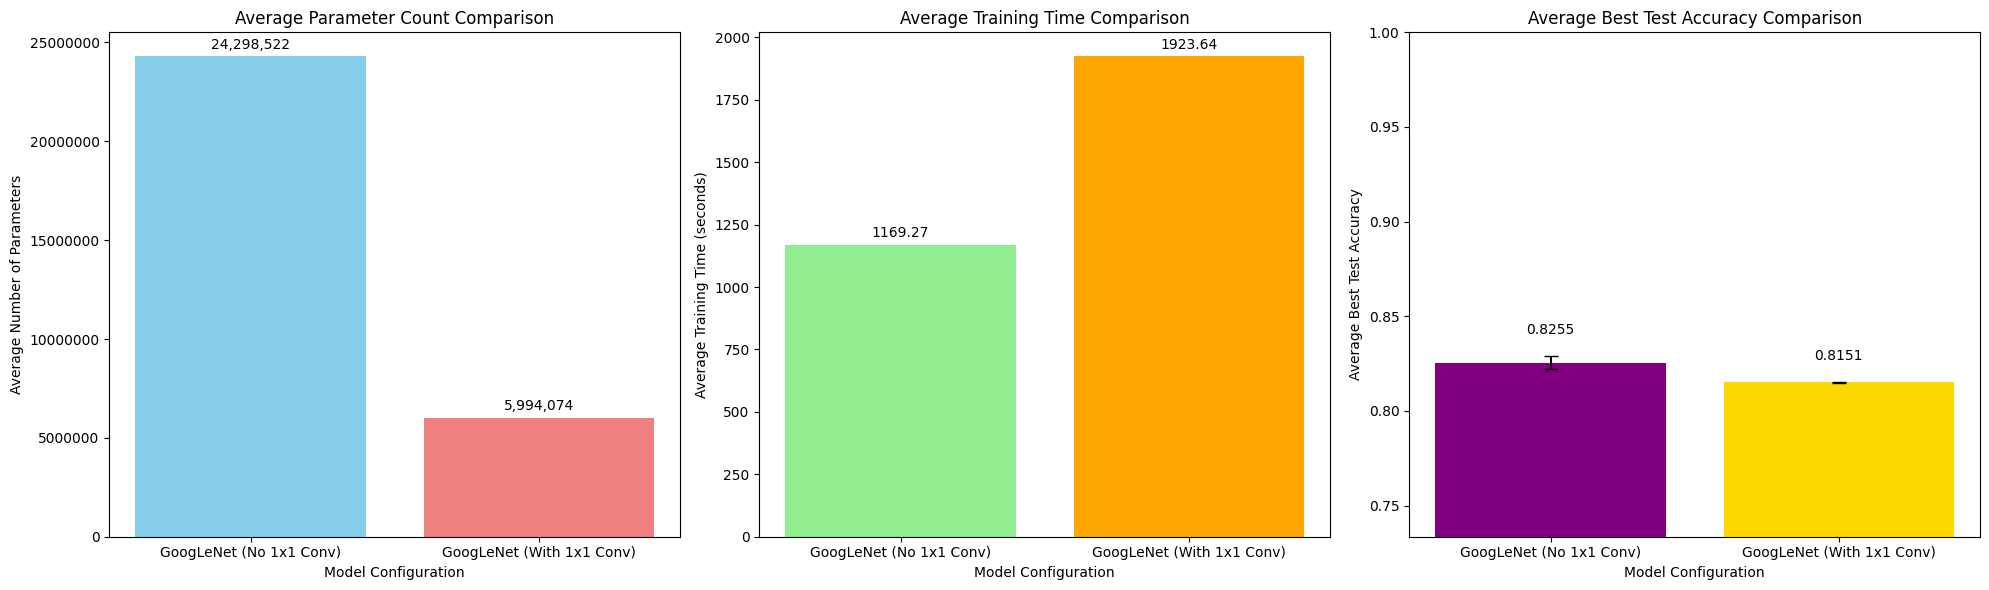

Average comparison plot saved to ./results/googlenet_comparison_avg.png


In [57]:
# Main Experiment Execution

if __name__ == "__main__":
    train_loader, test_loader = get_dataloaders(
        CONFIG["data_root"],
        CONFIG["batch_size"],
    )

    # Dictionary to store results from all runs for averaging
    all_runs_results = defaultdict(list)
    final_best_accuracies = defaultdict(list)

    seeds = [17, 786, 945]
    print(f"Running experiments with seeds: {seeds}")

    device = CONFIG['device']

    # --- Experiment Loop ---
    for i, seed in enumerate(seeds):
        print(f"\nRunning Experiment Run: {i} / Seed: {seed}")
        set_seed(seed)

        # --- Sub-Exp 1: GoogLeNet without 1x1 Convolution ---
        print("\n--- Model: GoogLeNet without 1x1 Convolution ---")
        model_no_1x1 = GoogLeNet(CONFIG["num_classes"], use_1x1=False).to(CONFIG["device"])

        model_save_path_no_1x1 = os.path.join(CONFIG["model_save_dir"], f"best_model_no_1x1_run{i+1}.pth")

        _, _, time_no_1x1, best_acc_no_1x1, epochs_trained_no_1x1 = train_model(
            model_no_1x1,
            train_loader,
            test_loader,
            device,
            model_save_path_no_1x1,
        )
        all_runs_results["GoogLeNet (No 1x1 Conv)"].append({
            'params': num_params_no_1x1,
            'time': time_no_1x1,
            'best_acc': best_acc_no_1x1,
            'epochs_trained': epochs_trained_no_1x1
        })
        final_best_accuracies["GoogLeNet (No 1x1 Conv)"].append(best_acc_no_1x1)

        print(f"\nRun {i+1} Best Test Accuracy (without 1x1 conv): {best_acc_no_1x1:.4f}")
        print(f"Run {i+1} Training time (without 1x1 conv): {time_no_1x1:.2f} seconds")
        print(f"Run {i+1} Epochs trained (without 1x1 conv): {epochs_trained_no_1x1}")

        # --- Sub-Experiment 2: GoogLeNet with 1x1 Convolution ---
        print("\n--- Model: GoogLeNet with 1x1 Convolution ---")
        model_with_1x1 = GoogLeNet(CONFIG["num_classes"], use_1x1=True).to(CONFIG["device"])
        num_params_with_1x1 = count_parameters(model_with_1x1)
        model_save_path_with_1x1 = os.path.join(CONFIG["model_save_dir"], f"best_model_with_1x1_run{i+1}.pth")

        _, _, time_with_1x1, best_acc_with_1x1, epochs_trained_with_1x1 = train_model(
            model_with_1x1,
            train_loader,
            test_loader,
            device,
            model_save_path_with_1x1,
        )
        all_runs_results["GoogLeNet (With 1x1 Conv)"].append({
            'params': num_params_with_1x1,
            'time': time_with_1x1,
            'best_acc': best_acc_with_1x1,
            'epochs_trained': epochs_trained_with_1x1
        })
        final_best_accuracies["GoogLeNet (With 1x1 Conv)"].append(best_acc_with_1x1)

        print(f"\nRun {i+1} Best Test Accuracy (with 1x1 conv): {best_acc_with_1x1:.4f}")
        print(f"Run {i+1} Training time (with 1x1 conv): {time_with_1x1:.2f} seconds")
        print(f"Run {i+1} Epochs trained (with 1x1 conv): {epochs_trained_with_1x1}")


    # --- Summarize and Plot Average Results ---
    print("\n--- Averaging Results Across All Runs ---")
    print("\n--- Average Performance Summary ---")
    for model_name, results_list in all_runs_results.items():
        avg_acc = np.mean([res['best_acc'] for res in results_list])
        std_acc = np.std([res['best_acc'] for res in results_list])
        avg_time = np.mean([res['time'] for res in results_list])
        std_time = np.std([res['time'] for res in results_list])
        avg_params = np.mean([res['params'] for res in results_list]) 
        avg_epochs = np.mean([res['epochs_trained'] for res in results_list])

        print(f"\nModel: {model_name}")
        print(f"  Average Parameters: {avg_params:,.0f}")
        print(f"  Average Best Test Accuracy: {avg_acc:.4f} (Std: {std_acc:.4f})")
        print(f"  Average Training Time: {avg_time:.2f} seconds (Std: {std_time:.2f})")
        print(f"  Average Epochs Trained: {avg_epochs:.1f}")

    print("\n--- Plotting Average Results ---")
    plot_average_results(all_runs_results, CONFIG["plot_save_path"])

![inception_module.png](./inception_module.png)

## 실험 결과 요약

| **Inception module** | **1** | **2** | **3** | **4** | **5** | **평균 정확도** | **평균 학습 시간 (s)** | **파라미터 수** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **with 1×1 conv** | 0.7415 | 0.8076 | 0.8157 | 0.8148 | 0.8147 | **0.7988** | **1923.64** | **320,042** |
| **without 1×1 conv** | 0.7635 | 0.8302 | 0.8243 | 0.8301 | 0.8222 | **0.8140** | **1169.27** | **661,386** |

## 분석

1. 정확도 측면
- 1×1 convolution을 사용하지 않은 모델이 더 높은 평균 정확도(0.8141) 를 기록하였다.
- 이는 1×1 conv 없이 더 많은 파라미터를 직접 3×3, 5×5에 할당할 수 있어 모델 표현력이 증가했기 때문으로 보인다.

2. 파라미터 수 측면
- 1×1 conv를 사용한 경우 파라미터 수는 약 32만 개로, 미사용한 경우(약 66만 개)의 절반 수준이었다.
- 이는 1×1 conv가 채널을 효과적으로 축소하여 후속 conv의 연산량과 파라미터를 줄여주는 역할을 함을 확인할 수 있다.

3. 학습 시간 측면
- 흥미롭게도, 파라미터 수가 적음에도 불구하고 1×1 conv를 포함한 모델은 학습 시간이 평균 1.6배 이상 더 오래 걸렸다.
- 이는 다음과 같은 요인에 의해 발생한 것으로 분석된다:
	- 1×1 conv는 메모리 접근은 적지만 feature map 전체에 작고 얕은 연산을 반복적으로 적용해야 하므로, 연산량은 줄지 않음
	- 병렬 branch 처리 시 병목 현상이나 GPU에서의 연산 최적화 한계가 발생할 수 있음
	- 작은 conv 연산들이 많아지면 kernel launch overhead가 커져 실제 처리 시간이 길어질 수 있음


### 기대와 다른 결과

1×1 convolution을 사용하는 구조가 연산량을 줄이고 정규화 효과도 있기 때문에, 일반적으로 더 나은 성능과 빠른 학습을 기대했지만,
본 실험에서는 1×1 conv가 없는 구조가 더 높은 정확도와 짧은 학습 시간을 보였다.

### 기대와 다른 결과에 대한 원인 분석

본 실험에서는 일반적으로 연산량 감소와 정보 결합의 장점이 있는 1×1 convolution layer를 도입한 Inception 구조가, 오히려 그렇지 않은 구조보다 낮은 정확도와 더 긴 학습 시간을 보이는 결과를 나타냈다. 이는 이론적 기대와 상반된 결과로, 다음과 같은 요인들이 복합적으로 작용했을 가능성이 있다.

1. 채널 압축에 따른 정보 손실
- 1×1 convolution은 주로 채널 수를 줄이는 데 사용되며, 이는 연산량을 줄이는 데 효과적이다. 그러나 채널 수를 과도하게 줄일 경우, 중요한 특성 정보까지 손실될 수 있다. 이는 전체 표현력 저하로 이어져 모델 성능 하락의 원인이 될 수 있다.

2. 연산 구조상의 비효율성
- 1×1 convolution은 이론적으로 연산량이 적지만, 실제 구현 측면에서는 각 채널에 대한 개별 접근이 많아 메모리 병목 현상이 발생할 수 있다. 특히 PyTorch와 같은 프레임워크에서는 이러한 구조가 GPU 병렬 처리 효율에 영향을 주어 오히려 전체 학습 시간이 증가할 수 있다.

3. 파라미터 부족에 따른 모델 용량 저하
- 1×1 convolution을 도입하면 전체 모델의 파라미터 수가 줄어든다. 이는 계산 효율에는 긍정적일 수 있으나, 학습 가능한 표현의 폭이 좁아져 underfitting이 발생할 수 있다. 특히 CIFAR-10과 같은 복잡한 분류 문제에서는 일정 수준 이상의 모델 용량이 필요하다.

4. 구조 차이를 고려하지 않은 하이퍼파라미터 설정
- 두 실험 모델은 구조적으로 상당한 차이를 가지나, 동일한 학습률과 optimizer 설정을 적용하였다. 이는 구조에 최적화되지 않은 학습 조건이 되었을 가능성이 있으며, 특히 파라미터 수가 적은 모델은 더 섬세한 학습 조건이 요구된다.

5. Gradient 흐름의 차이
- 1×1 convolution이 삽입된 구조에서는 gradient가 더 많은 층과 연산을 거치게 되어 역전파 과정이 복잡해진다. 이로 인해 초기 층에서 gradient가 약화되거나 중요한 정보가 손실될 수 있으며, 이는 전체 학습의 효율성을 저하시킬 수 있다.


## 결론

본 실험을 통해 1×1 convolution이 파라미터 수를 줄이는 데는 효과적이나, 실제 학습 시간 단축에는 직접적인 기여를 하지 못할 수 있음을 확인하였다. 특히 1×1 conv를 포함한 구조는 오히려 연산 효율 저하와 성능 감소를 초래했으며, 이는 단순한 모델 경량화가 반드시 학습 속도나 정확도 향상으로 이어지지 않음을 보여준다.

반면, 1×1 conv를 제거한 구조는 더 많은 파라미터를 가지면서도 학습 시간과 정확도 측면에서 일관된 우수한 성능을 보였다. 이는 모델 설계 시 단순한 압축보다는 표현력과 계산 효율성 간의 균형이 더 중요하다는 점을 시사한다. 향후 모델 최적화 과정에서는 연산 구조의 실제 효율과 정보 손실 가능성을 함께 고려해야 할 것이다.